In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import string
import random
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

from scipy.stats import norm,skew
from scipy import stats
from sklearn.metrics.classification import log_loss
from sklearn.model_selection import train_test_split

import helper as hp
import textProcessingHelper as tp
import plotHelper as ph
import matrixHelper as mh
import costFunctionHelper as ch

In [2]:
df = pd.read_csv("./data/trainingData.csv")
df.shape

(40000, 21)

In [3]:
pd.DataFrame(df.dtypes).rename(columns={0:'dtype'})

,dtype
Id,int64
city,object
age,int64
sex,object
social_class,object
primary_business,object
secondary_business,object
annual_income,float64
monthly_expenses,float64
old_dependents,int64


* There are multiple types of features
* Out of 21 features 7 of the features are object(includes string values in the variable)
* Correct the spell of water_availabity columns

In [4]:
df = df.rename({"water_availabity": "water_availability"}, axis=1)
df.describe() 

,Id,age,annual_income,monthly_expenses,old_dependents,young_dependents,home_ownership,occupants_count,house_area,sanitary_availability,water_availability,loan_tenure,loan_installments,loan_amount
count,40000.00000,40000.00000,4.000000e+04,39880.000000,40000.000000,40000.00000,39621.000000,40000.000000,40000.000000,39792.000000,34747.000000,40000.000000,40000.000000,4.000000e+04
mean,20000.50000,55.15990,3.764021e+04,3810.875401,0.044900,1.13710,0.972489,26.641000,552.804750,0.686369,0.753216,12.032225,21.761175,8.412593e+03
std,11547.14972,3830.35566,2.873912e+04,4592.958009,0.222003,1.07384,0.163568,4749.995485,4596.921905,0.464028,0.255337,1.367473,16.682458,1.359694e+04
min,1.00000,2.00000,0.000000e+00,2.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-1.000000,-1.000000,3.000000,0.000000,1.000000e+02
25%,10000.75000,29.00000,1.440000e+04,2500.000000,0.000000,0.00000,1.000000,2.000000,200.000000,0.000000,0.500000,12.000000,12.000000,5.000000e+03
50%,20000.50000,35.00000,3.600000e+04,3500.000000,0.000000,1.00000,1.000000,3.000000,400.000000,1.000000,1.000000,12.000000,12.000000,8.000000e+03
75%,30000.25000,42.00000,5.600000e+04,4000.000000,0.000000,2.00000,1.000000,4.000000,600.000000,1.000000,1.000000,12.000000,50.000000,1.000000e+04
max,40000.00000,766105.00000,1.200000e+06,240000.000000,3.000000,7.00000,1.000000,950000.000000,700000.000000,1.000000,1.000000,84.000000,84.000000,1.343000e+06


### Initial observation
* Id,age, annual_income, monthly_expenses, house_area, loan_amount are continuous variable 
* There are unrealistic values for age(max=766105), occupants_count(max=950000), house_area(max=700000),loan_amount( rural small scale bussiness looking for loan amount over 25L)
* home_ownership, sanitary_availability, water_availabity, old_dependents, old_dependents, loan_tenure, loan_installments are Ordinal features

In [5]:
# Missing data
hp.missing_data_points(df)

,Total,Percent
social_class,5255,0.131375
water_availability,5253,0.131325
secondary_business,5241,0.131025
city,1864,0.046600
type_of_house,694,0.017350
home_ownership,379,0.009475
sanitary_availability,208,0.005200
monthly_expenses,120,0.003000
loan_purpose,26,0.000650
primary_business,26,0.000650


* Some features have missing values which needs the data imputation

###  Response variable `loan_amount` distribution

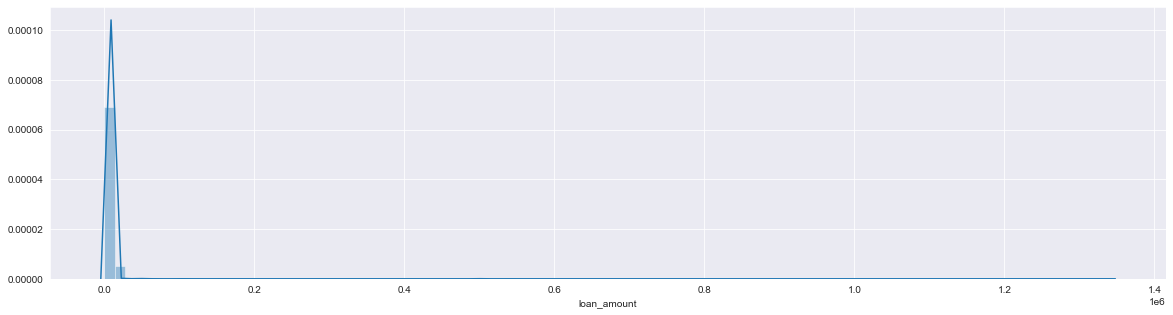

In [6]:
plt.figure(figsize=[20,5])
sns.distplot(df.loan_amount, bins=100)
plt.show()

In [7]:
print("Skewness: %f" % df['loan_amount'].skew())
print("Kurtosis: %f" % df['loan_amount'].kurt())

Skewness: 57.873098
Kurtosis: 4258.706925


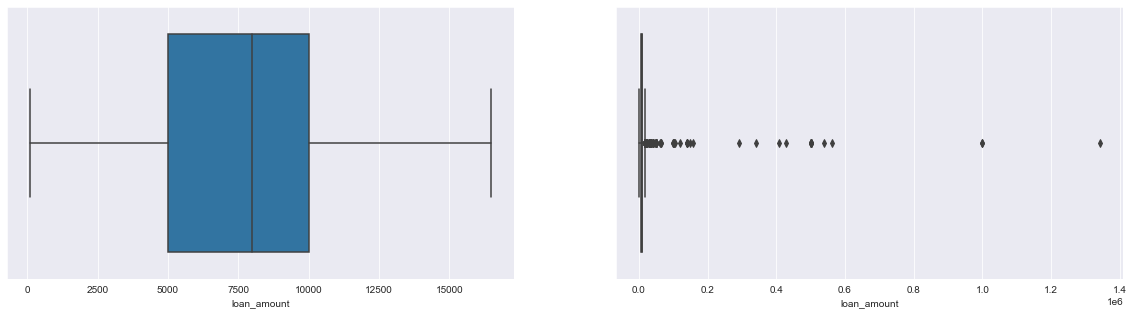

In [8]:
f,ax = plt.subplots(1,2, figsize=(20,5))
sns.boxplot(df.loan_amount, showfliers=False, ax=ax[0])
sns.boxplot(df.loan_amount, showfliers=True, ax=ax[1])
plt.show()

* target variable, loan_amount is not normally distributed.
* There are multiple outliers in the variable.
* Treating the outliers by removing the any data point below and above the 1.5*IQR.  

#### Outlier treatment

In [9]:
lowerbound,upperbound = hp.outlier_treatment(df.loan_amount)

print("Lower loan amount range", lowerbound)
print("Upper loan amount range", upperbound)

df[(df.loan_amount < lowerbound) | (df.loan_amount > upperbound)].shape

Lower loan amount range -2500.0
Upper loan amount range 17500.0


(203, 21)

Remove the data points which are lower than lowerbound and higher than the upperbound

In [10]:
df_clean = df.copy()
df_clean.drop(df_clean[(df_clean.loan_amount > upperbound) | (df_clean.loan_amount < lowerbound) ].index, inplace=True)

Skewness: 0.600687


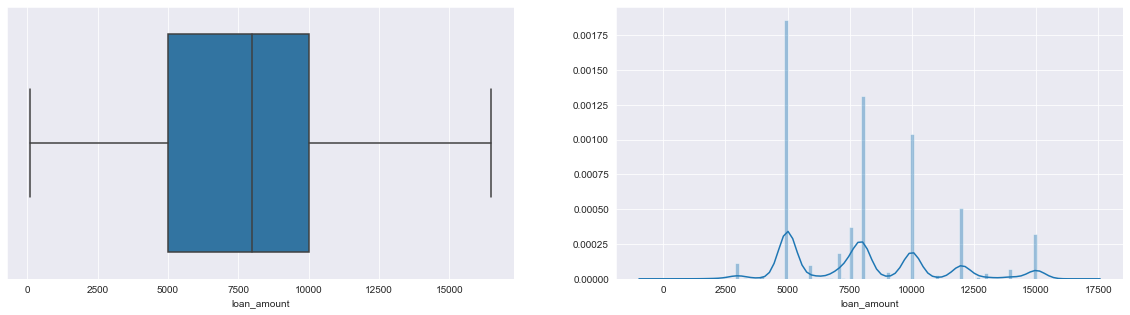

In [11]:
f,ax = plt.subplots(1,2, figsize=(20,5))
sns.boxplot(df_clean.loan_amount, showfliers=False, ax=ax[0])
sns.distplot(df_clean.loan_amount, bins=100,ax=ax[1])
print("Skewness: %f" % df_clean['loan_amount'].skew())

After the outlier removal. Loan amount can be classified into sorted categaries. 

* Machine learning tasks would be classification.  


In [12]:
print("Minimum loan amount", df_clean.loan_amount.min())
print("Maximum loan amount", df_clean.loan_amount.max())

Minimum loan amount 100.0
Maximum loan amount 16500.0


In [13]:
df_clean['max_loan_amount']=0

df_clean.loc[(df_clean.loan_amount >= 0) & (df_clean.loan_amount < 2000), 
             'max_loan_amount'] = 0

df_clean.loc[(df_clean.loan_amount >= 2000) & (df_clean.loan_amount < 5000), 
             'max_loan_amount'] = 2000

df_clean.loc[(df_clean.loan_amount >= 5000) & (df_clean.loan_amount < 7000), 
             'max_loan_amount'] = 5000

df_clean.loc[(df_clean.loan_amount >= 7000) & (df_clean.loan_amount < 8000), 
             'max_loan_amount'] = 7000

df_clean.loc[(df_clean.loan_amount >= 8000) & (df_clean.loan_amount < 10000), 
             'max_loan_amount'] = 8000

df_clean.loc[(df_clean.loan_amount >= 10000) & (df_clean.loan_amount < 12000), 
             'max_loan_amount'] = 10000

df_clean.loc[(df_clean.loan_amount >= 12000) & (df_clean.loan_amount < 15000), 
             'max_loan_amount'] = 12000

df_clean.loc[(df_clean.loan_amount >= 15000) & (df_clean.loan_amount < 20000), 
             'max_loan_amount'] = 15000

df_clean = df_clean.drop(df_clean[df_clean['max_loan_amount'] == 0].index)



In [14]:
# Diffrence in loan amount     
total_amount_approved = df_clean['max_loan_amount'].sum()
total = df_clean['loan_amount'].sum()

print("Total loan amount approved:", total_amount_approved, '₹')
print("Total initial loan amount:", total, '₹')
print("% of diffrence in loan amount after binning:" + "{:.2f}".format(((total - total_amount_approved)/total)*100), '%')


Total loan amount approved: 315725000 ₹
Total initial loan amount: 320612600.0 ₹
% of diffrence in loan amount after binning:1.52 %


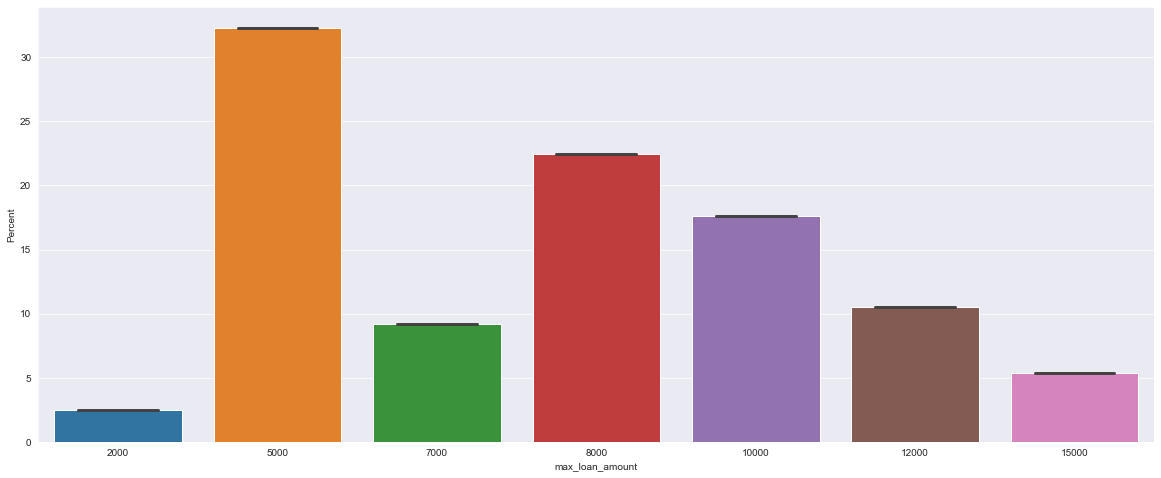

,count,percentage
max_loan_amount,,
2000,998,0.025085
5000,12858,0.323187
7000,3666,0.092145
8000,8936,0.224607
10000,7017,0.176373
12000,4177,0.104989
15000,2133,0.053613


In [15]:
ph.cust_bar_plot_per(df=df_clean,
                 x='max_loan_amount',
                 y='max_loan_amount')  

hp.count_percentage(df_clean, 'max_loan_amount')

* Target variable has Imbalanced data categories can affect the performance of the model. Should consider balancing the categories or consider the model which work well with the inbalanced data

## Predictor object variable analysis `loan_purpose`, `primary_business`, `secondary_business`

`loan_purpose`

It is a string varible which contains the applicants loan purpose


* There are data points with missing values for the loan_purpose. For any applicant there has to be reason for loan. Will be filling the missing values with **Others**.
* How relavent the loan purpose and the applicants business mentioned?
* Is the loan purpose is a investment or expenses? 

Should perform the text processing to understand the spread of loan_purpose

In [16]:
# Assign the missing values as "Others"
df_clean['loan_purpose'] = df_clean['loan_purpose'].fillna('Others')
print("Is loan_purpose missing:", df_clean['loan_purpose'].isnull().any())

Is loan_purpose missing: False


In [17]:
df_clean['loan_purpose'] = df_clean['loan_purpose'].apply(lambda x:x.lower())

df_clean['loan_purpose'] = df_clean['loan_purpose'].apply(lambda x:tp.scrub_words(x))
df_clean['loan_purpose'].replace(['retail store'],
                               'retail sale'
                               ,inplace=True)

In [18]:
hp.count_percentage_mode(df_clean, 'loan_purpose', 'max_loan_amount')

,count,percentage,mode
loan_purpose,,,
agarbatti business,107,0.002689,5000
agro based businesses,4723,0.118713,5000
animal husbandry,4415,0.110971,5000
apparels,7055,0.177328,8000
artifical jewellry selling,556,0.013975,5000
beauty salon,204,0.005128,5000
business services i,276,0.006937,5000
business services ii,854,0.021465,10000
cable tv services,5,0.000126,7000


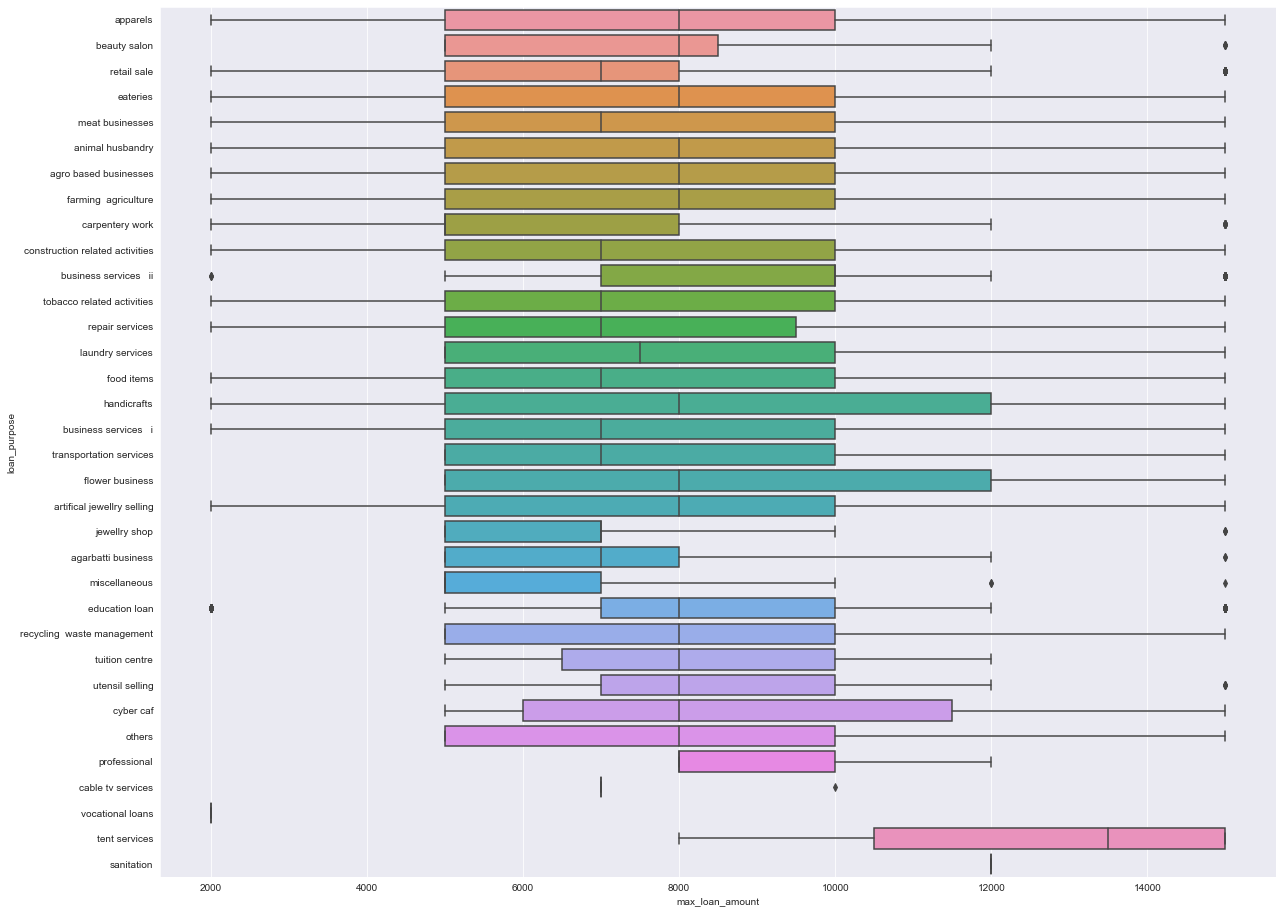

In [19]:
ph.customize_box_plot(df=df_clean,
                      x='max_loan_amount',
                      orient='h',
                      y='loan_purpose',
                      height=16)

* There are 34 different categories of loan purpose mentioned. 
* Can these categories grouped as investments and expenses  e.g: Education Loan, Vocational Loans
* There are few categories which doesn't explains loan purpose clearly - e.g: miscellaneous, others, professional, business service  I and II
* Loan amount approved for services like **repair service** , **beauty salon**, **cable tv services** varies, we can't group them as services, product, low investments business
* There could be other varibles which could explain the target better.


`primary_business` and `secondary_business`

* Filling the missing data by none

In [20]:
for col in ['primary_business', 'secondary_business']:
    df_clean[col]=df_clean[col].fillna('none')

In [21]:
# Remove punctuation
df_clean['primary_business_clean'] = df_clean['primary_business'].apply(lambda x:tp.remove_punctuation(x))

# 2. Lowercasing
df_clean['primary_business_clean'] = df_clean['primary_business_clean'].apply(lambda x:x.lower())

# 3. Tokenization
df_clean['primary_business_clean'] = df_clean['primary_business_clean'].apply(lambda x:tp.tokenize(x))  

# 3. Remove the stop words
df_clean['primary_business_clean'] = df_clean['primary_business_clean'].apply(lambda x:tp.remove_stopwords(x))

# 4. Lemmatizing 
df_clean['primary_business_clean'] = df_clean['primary_business_clean'].apply(lambda x:tp.lemmatizing(x))

df_clean['primary_business_clean']=df_clean['primary_business_clean'].apply(lambda x: " ".join(str(i) for i in x))
    

In [22]:
hp.count_percentage_mode(df_clean, 'primary_business_clean', 'loan_purpose')

,count,percentage,mode
primary_business_clean,,,
11th 12th,170,0.004273,education loan
accessory vendor,90,0.002262,artifical jewellry selling
agarbati making,1,0.000025,agarbatti business
agarbati making selling,1,0.000025,agarbatti business
agarbatti sale,105,0.002639,agarbatti business
...,...,...,...
wooden apple bead making,18,0.000452,handicrafts
wooden toy business,39,0.000980,handicrafts
wool knitting,1,0.000025,others


In [23]:
hp.count_percentage_mode(df_clean, "secondary_business","max_loan_amount")

,count,percentage,mode
secondary_business,,,
Agriculture,2094,0.052633,5000
Daily wage labourer,2543,0.063919,5000
Livestock rearing,179,0.004499,5000
Others,2544,0.063944,5000
none,32425,0.815006,5000


* Primary business has around over 400 categories which also includes none and others. 
* Its hard to explain the target variable based on primary business as applicant with same bussiness approved with diffrent loan amounts. 
* Presence of secondary business can increase chance of applicant to get higher loan amount

Assigning secondary_business = 1 for applicants with secondary business otherwise 0

In [24]:
df_clean.loc[~df_clean['secondary_business'].isin(['none']), 'secondary_business'] = 1
df_clean.loc[df_clean['secondary_business'].isin(['none']), 'secondary_business'] = 0

# Dropping ID and loan amount column
df_clean = df_clean.drop(['Id',
                          'loan_amount'], 
                           axis=1)

In [25]:
## Getting the correlation of all the features with target variable without the outlier removal. 
(df_clean.corr()**2)["max_loan_amount"].sort_values(ascending = False)[1:]

annual_income            9.685318e-02
water_availability       8.762042e-02
sanitary_availability    3.003431e-02
loan_tenure              1.983780e-02
loan_installments        1.575031e-02
young_dependents         1.428649e-02
home_ownership           2.092319e-03
monthly_expenses         1.605298e-03
old_dependents           7.229095e-04
house_area               3.286619e-04
age                      9.639668e-05
occupants_count          4.272304e-08
Name: max_loan_amount, dtype: float64

These are the predictor variables sorted in a descending order starting with the most correlated one **annual_income**.

### Predictor variable `annual_income`

In [26]:
lowerbound,upperbound = hp.outlier_treatment(df_clean.annual_income)
df_clean.drop(df_clean[(df_clean.annual_income > upperbound) | (df_clean.annual_income < lowerbound) ].index, inplace=True)

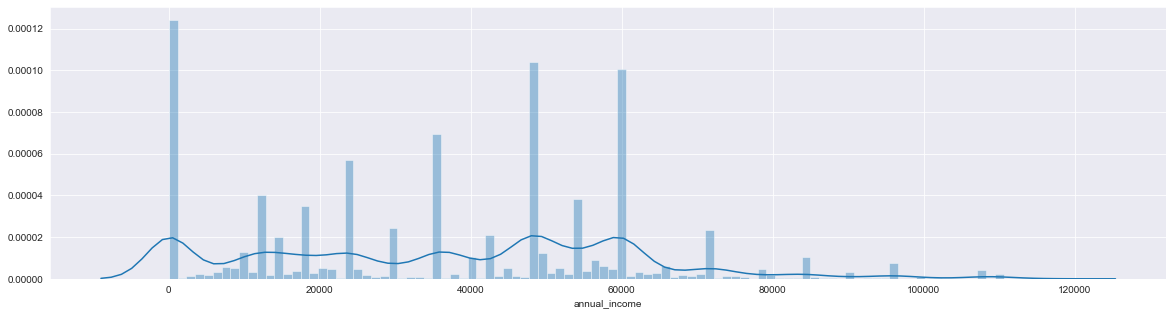

In [27]:
plt.figure(figsize=[20, 5])
sns.distplot(df_clean.annual_income, bins=100)
plt.show()

In [28]:
df_clean['annual_income_band']=0
df_clean.loc[df_clean.annual_income == 0, 'annual_income_band'] = 0
df_clean.loc[(df_clean.annual_income > 0) & (df_clean.annual_income <= 10000), 'annual_income_band'] = 10000
df_clean.loc[(df_clean.annual_income > 10000) & (df_clean.annual_income <= 20000), 'annual_income_band'] = 20000
df_clean.loc[(df_clean.annual_income > 20000) & (df_clean.annual_income <= 40000), 'annual_income_band'] = 40000
df_clean.loc[(df_clean.annual_income > 40000) & (df_clean.annual_income <= 50000), 'annual_income_band'] = 50000
df_clean.loc[(df_clean.annual_income > 50000) & (df_clean.annual_income <= 60000), 'annual_income_band'] = 60000
df_clean.loc[(df_clean.annual_income > 60000) & (df_clean.annual_income <= 90000), 'annual_income_band'] = 90000
df_clean.loc[(df_clean.annual_income > 90000) & (df_clean.annual_income <= 100000), 'annual_income_band'] = 100000
df_clean.loc[df_clean.annual_income > 100000, 'annual_income_band'] = 120000

hp.count_percentage_mode(df_clean, 'annual_income_band', 'max_loan_amount')

,count,percentage,mode
annual_income_band,,,
0,5692,0.144229,5000
10000,1511,0.038287,5000
20000,5195,0.131636,5000
40000,8306,0.210465,5000
50000,6727,0.170455,8000
60000,7952,0.201495,8000
90000,3287,0.083289,8000
100000,438,0.011098,8000
120000,357,0.009046,12000


**Annual_income** is a ordinal variable.
* Anual income being lower, higher loan amount is approved this cound be because of home_ownership, house_area, age(young). 
* Even with higher annual income lower loan amount is approved this could be because of age(old), dependents, occupants_count, monthly_expenses.

In [29]:
## Cleaning data

df_clean = df_clean.drop(['annual_income'], 
                           axis=1)


### Predictor variable `loan_tenure`
Let's understand the relation between loan_tenure and annual_income

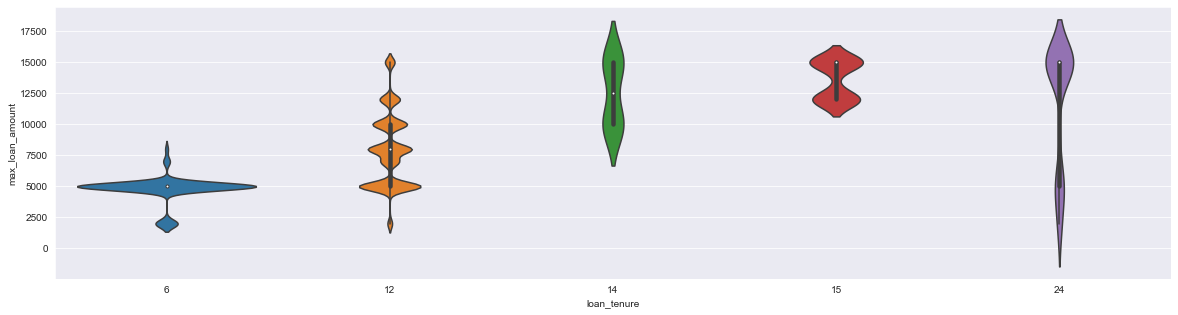

,count,percentage,mode
loan_tenure,,,
6,380,0.009629,5000
12,38816,0.983555,5000
14,10,0.000253,10000
15,53,0.001343,15000
24,206,0.005220,15000


In [30]:
ph.customize_violin_plot(x="loan_tenure", 
                      y="max_loan_amount",
                      df=df_clean)
hp.count_percentage_mode(df_clean, "loan_tenure","max_loan_amount")

**loan_tenure** indicates the number of months within which loan needs to be paid. It is an ordinal varible with values ranging from 6 to 24. 

* 98% of the loan is paid within 12 months
* Repayment of Loan amount more than 10K needs 14 to 24 months

### Predictor variable `loan_installments`

In [31]:
hp.count_percentage_mode(df_clean, "loan_installments","max_loan_amount")

,count,percentage,mode
loan_installments,,,
2,94,0.002382,10000
4,12,0.000304,10000
6,342,0.008666,5000
12,28514,0.722514,5000
15,53,0.001343,15000
24,207,0.005245,15000
50,10088,0.255619,5000
51,74,0.001875,5000
52,6,0.000152,5000


**loan_installments** paid and **loan_tenure** must be same or less(Early payment) for anyone to get good credit score. Looks like applicants had dues and have taken more time to pay the loan than the prescribed tenure. 

Lets Identify the number of months by which the repayment is delayed. As there are no missing data in both the variables subtraction should give the **n_repayment_due**. 

In [32]:
df_clean['n_repayment_due']=0
df_clean['n_repayment_due'] = df_clean.loan_installments - df_clean.loan_tenure 

In [33]:
hp.count_percentage_mode(df_clean, "n_repayment_due","max_loan_amount")

,count,percentage,mode
n_repayment_due,,,
-10,54,0.001368,10000
-8,12,0.000304,10000
-6,2,0.000051,5000
-4,40,0.001014,2000
0,29113,0.737692,5000
12,1,0.000025,5000
38,10088,0.255619,5000
39,74,0.001875,5000
40,6,0.000152,5000


* 74% of the applicant have paid the loan within the tenure 
* Around 25% of the applicant had dues
* 1% of the applicant have early repaymnets

Can this be used to predict loan repayment behaviour of the applicant?

Lets categorise the applicants based on the number months in dues

Introducing a column **repayment_behaviour**

In [34]:
df_clean['repayment_behaviour']=0

df_clean.loc[df_clean.n_repayment_due < 0, 'repayment_behaviour'] = "excellent"
df_clean.loc[df_clean.n_repayment_due == 0, 'repayment_behaviour'] = "very_good"
df_clean.loc[(df_clean.n_repayment_due > 0) & (df_clean.n_repayment_due <= 12), 'repayment_behaviour'] = "good"
df_clean.loc[(df_clean.n_repayment_due > 12) & (df_clean.n_repayment_due <= 24), 'repayment_behaviour'] = "fair"
df_clean.loc[(df_clean.n_repayment_due > 24) & (df_clean.n_repayment_due <= 48), 'repayment_behaviour'] = "poor"
df_clean.loc[df_clean.n_repayment_due > 48, 'repayment_behaviour'] = "bad"

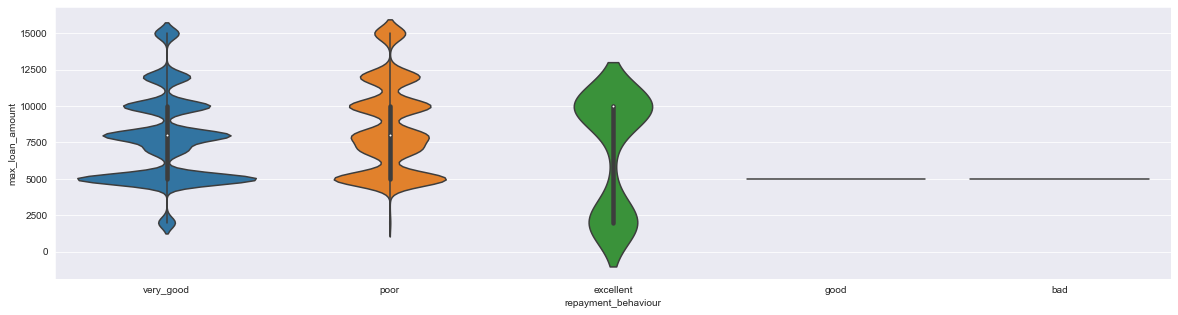

,count,percentage,mode
repayment_behaviour,,,
bad,11,0.000279,5000
excellent,108,0.002737,10000
good,1,0.000025,5000
poor,10232,0.259268,5000
very_good,29113,0.737692,5000


In [35]:
ph.customize_violin_plot(df=df_clean,
                         y='max_loan_amount',
                         x='repayment_behaviour')

hp.count_percentage_mode(df_clean, "repayment_behaviour","max_loan_amount")

In [36]:
# Adding weightage to repayment_behavior 

df_clean['repayment_behaviour'].replace(['bad', 'poor', 'fair', 'good', 'very_good', 'excellent'], [0,1,2,3,4,5], inplace=True)

#Clean data

df_clean = df_clean.drop(['n_repayment_due'], 
                           axis=1)

### Predictor variable `water_availabity`

In [37]:
hp.count_percentage_mode(df_clean, "water_availability", "max_loan_amount")

,count,percentage,mode
water_availability,,,
-1.0,1,0.000025,8000
0.0,181,0.004586,8000
0.5,16686,0.422805,5000
1.0,17353,0.439706,8000


water_availability = -1 could be because of the data entry mistake, mode of the `water_availability` will be assigned 

In [38]:
df_clean.loc[(df_clean.water_availability == -1.0)] = 1
hp.count_percentage_mode(df_clean, "water_availability", "max_loan_amount")

,count,percentage,mode
water_availability,,,
0.0,181,0.004586,8000
0.5,16686,0.422805,5000
1.0,17354,0.439731,8000


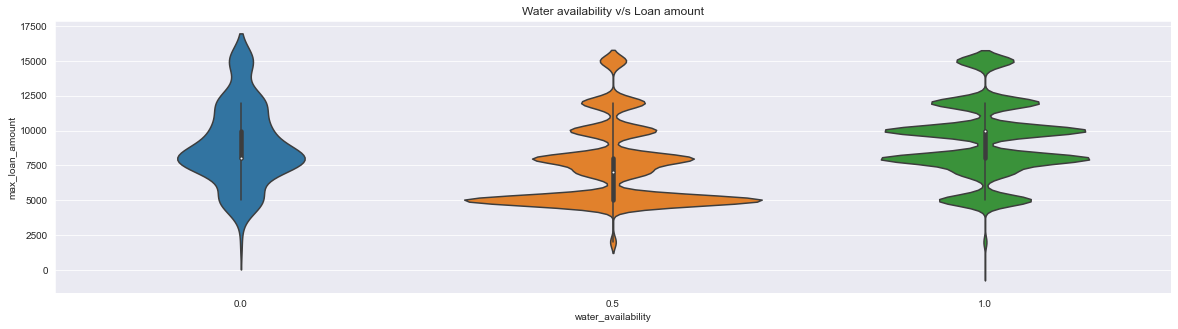

In [39]:
ph.customize_violin_plot(df=df_clean,
                         y='max_loan_amount',
                         x='water_availability',
                         title='Water availability v/s Loan amount')

**water_availability** can be considerd to have three levels 
* `No water available`, around 0.5% applicant belongs to this category
* `Limited water available`, around 42% applicant belongs to this category
* `Water available`, around 45% applicant belongs to this category
* For 12.5% applicant water_availability detail is missing(**`Data Imputation!`**)
* 50% of the `Limited water available` applicant has loan amount approved range between 5K to 10K


### Predictor varibale `sanitary_availability`

In [40]:
hp.count_percentage_mode(df_clean, "sanitary_availability", "max_loan_amount")

,count,percentage,mode
sanitary_availability,,,
0.0,12361,0.313214,5000
1.0,26901,0.681642,5000


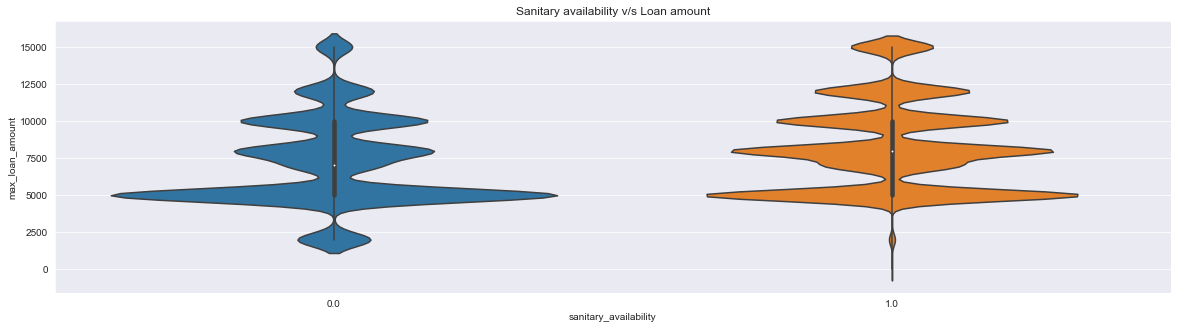

In [41]:
ph.customize_violin_plot(df_clean, 
                   y='max_loan_amount',
                   x='sanitary_availability',
                   title='Sanitary availability v/s Loan amount')

**sanitary_availability** 68% of the applicant has sanitary facility. 

* 1% of the data is missing should consider for **data imputations!**. 
* Applicant with sanitary availability likely to get loan amount of range from 7500 to 8000
* Lower loan amount of range from 500 to 3000 is approved for the applicant with no sanitary availability 
* Similary more people like to get loan amount of 15k who has sanitary availability


Lets see is there a relationship between `sanitary_availability` and `water_availability!`

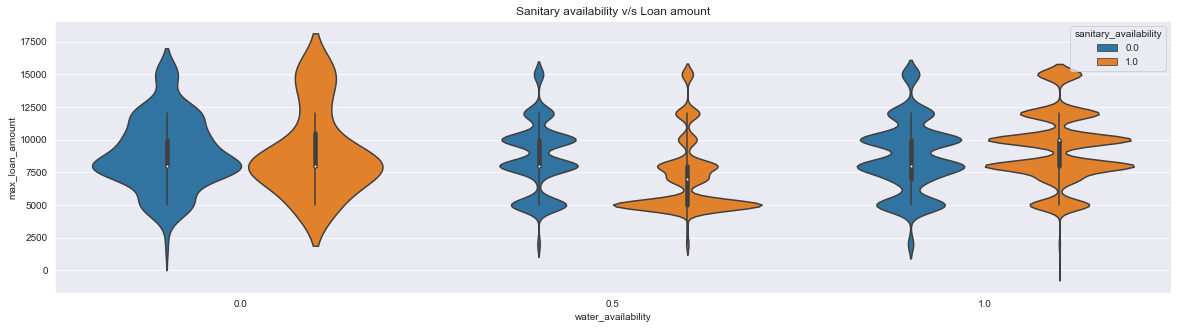

water_availability,0.0,0.5,1.0,All
sanitary_availability,,,,
0.0,145,4362,2813,7320
1.0,36,12324,14541,26901
All,181,16686,17354,34221


In [42]:
ph.customize_violin_plot(df_clean, 
                   y='max_loan_amount',
                   x='water_availability',
                   hue='sanitary_availability',
                   title='Sanitary availability v/s Loan amount')

ph.customize_cross_tab(row_list=[df_clean.sanitary_availability],
                    col_list=[df_clean.water_availability])

* If there is water most likely(78%) that sanitary is available
* 20% of the applicant in spite of having water availability sanitary is not available
* Applicant with max loan amount 5000 likely to have sanitary availability

### Predictor variable `monthly_expenses`

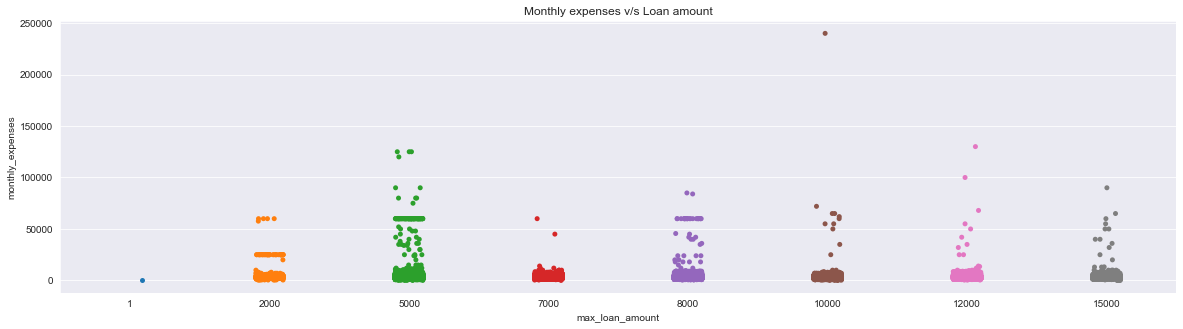

In [43]:
ph.customize_strip_plot(df=df_clean,
                        y='monthly_expenses', 
                        x='max_loan_amount', 
                        title='Monthly expenses v/s Loan amount',
                        width=20,
                        height=5)

* Lower expenses applicant can get either lower amount or highr amount depends on other factors
* Monthly expenses 250000 and looking for 10000 loan.
* Mostly the monthly expenses are below 7K 

In [44]:
lowerbound,upperbound = hp.outlier_treatment(df.monthly_expenses)
df_clean.drop(df_clean[(df_clean.monthly_expenses > upperbound) | (df_clean.monthly_expenses < lowerbound) ].index, 
              inplace=True)

In [45]:
df_clean['monthly_expenses_band']=  0
df_clean.loc[(df_clean.monthly_expenses <= 1000), 'monthly_expenses_band'] = 1000
df_clean.loc[(df_clean.monthly_expenses > 1000) & (df_clean.monthly_expenses <= 1500), 'monthly_expenses_band'] = 1500
df_clean.loc[(df_clean.monthly_expenses > 1500) & (df_clean.monthly_expenses <= 2000), 'monthly_expenses_band'] = 2000
df_clean.loc[(df_clean.monthly_expenses > 2000) & (df_clean.monthly_expenses <= 2500), 'monthly_expenses_band'] = 2500
df_clean.loc[(df_clean.monthly_expenses > 2500) & (df_clean.monthly_expenses <= 3000), 'monthly_expenses_band'] = 3000
df_clean.loc[(df_clean.monthly_expenses > 3000) & (df_clean.monthly_expenses <= 3500), 'monthly_expenses_band'] = 3500
df_clean.loc[(df_clean.monthly_expenses > 3500) & (df_clean.monthly_expenses <= 4000), 'monthly_expenses_band'] = 4000
df_clean.loc[(df_clean.monthly_expenses > 4000) & (df_clean.monthly_expenses <= 4500), 'monthly_expenses_band'] = 4500
df_clean.loc[(df_clean.monthly_expenses > 4500) & (df_clean.monthly_expenses <= 5000), 'monthly_expenses_band'] = 5000
df_clean.loc[(df_clean.monthly_expenses > 5000) & (df_clean.monthly_expenses <= 6000), 'monthly_expenses_band'] = 6000
df_clean.loc[df_clean.monthly_expenses > 6000, 'monthly_expenses_band'] = 6500

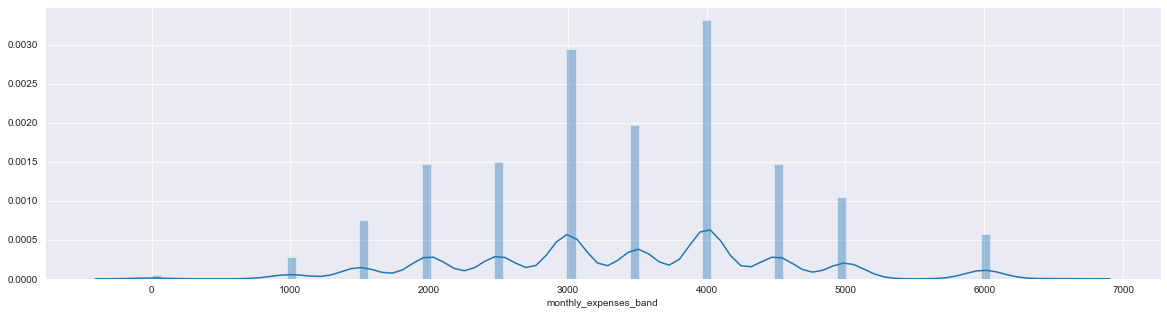

In [46]:
plt.figure(figsize=[20,5])
sns.distplot(df_clean.monthly_expenses_band, bins=100)
plt.show()

In [47]:
hp.count_percentage(df_clean, 'monthly_expenses_band')

,count,percentage
monthly_expenses_band,,
0,120,0.003134
1000,690,0.018021
1500,1864,0.048684
2000,3670,0.095852
2500,3731,0.097446
3000,7342,0.191757
3500,4900,0.127977
4000,8254,0.215577
4500,3655,0.095461


### Predictor variable `old_dependents`, `young_dependents` and `occupants_count`

* It would we good to see effect of these variables on monthly_expenses and annual income 

In [48]:
hp.count_percentage_mode(df_clean, "old_dependents","max_loan_amount")

,count,percentage,mode
old_dependents,,,
0,36716,0.958943,5000
1,1461,0.038158,5000
2,111,0.002899,10000


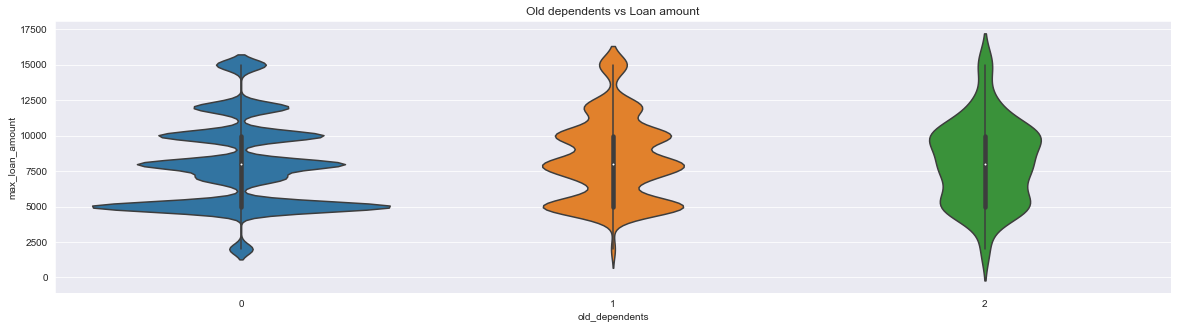

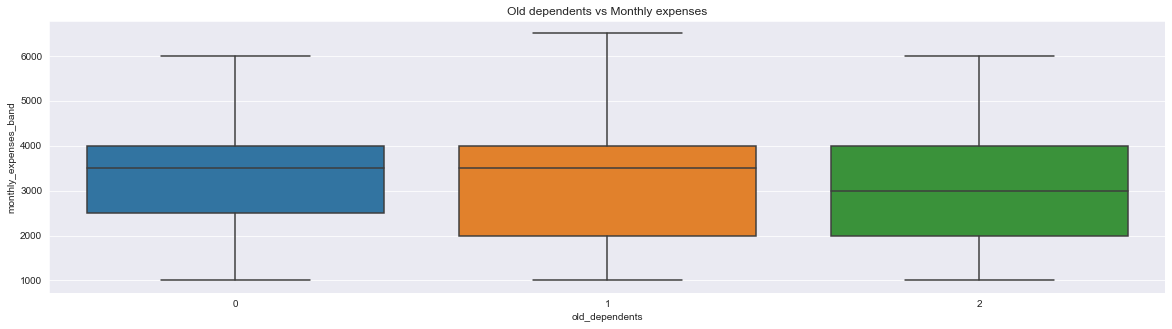

In [49]:
ph.customize_violin_plot(df=df_clean,
                        y='max_loan_amount', 
                        x='old_dependents', 
                        title='Old dependents vs Loan amount')

ph.customize_box_plot(df=df_clean,
                      y='monthly_expenses_band', 
                      x='old_dependents', 
                      title='Old dependents vs Monthly expenses',
                      showfliers=False)

**old_dependents** 95% of the applicant do not have any old dependents. 

With the old dependents expenses are more compair to without any

In [50]:
hp.count_percentage_mode(df_clean, "young_dependents","monthly_expenses_band")

,count,percentage,mode
young_dependents,,,
0,14214,0.371239,3000
1,9485,0.247728,4000
2,10841,0.283144,4000
3,3054,0.079764,4000
4,591,0.015436,4000
5,81,0.002116,4000
6,18,0.000470,4000
7,4,0.000104,6000


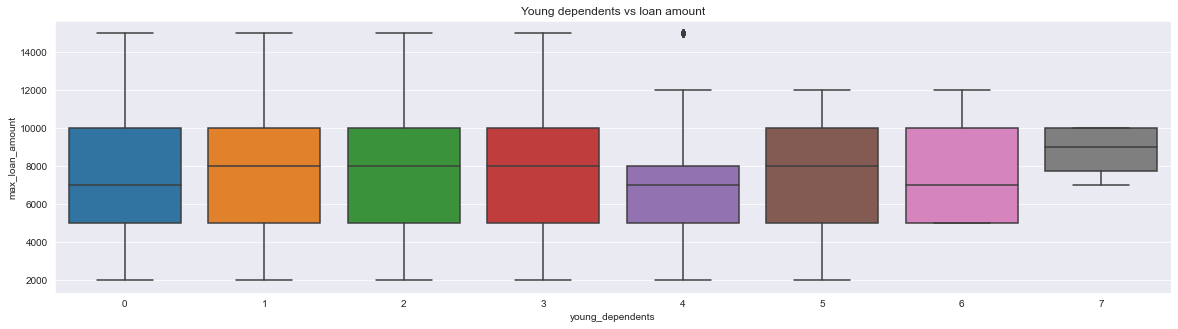

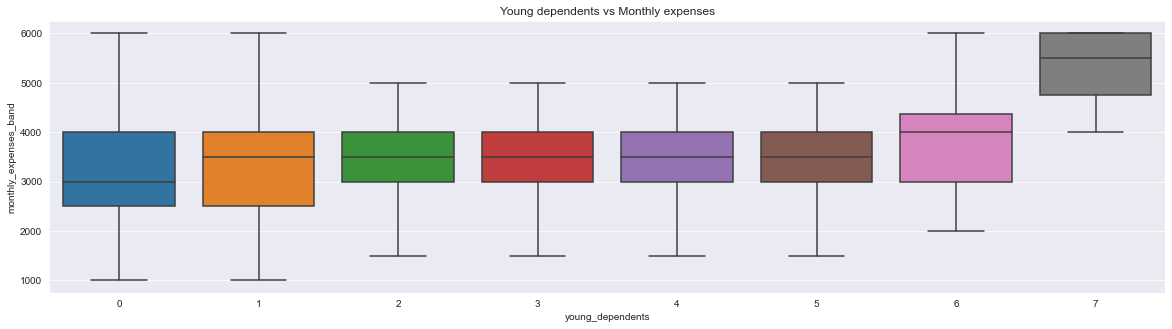

In [51]:
ph.customize_box_plot(df=df_clean,
                     y='max_loan_amount', 
                     x='young_dependents', 
                     title='Young dependents vs loan amount')

ph.customize_box_plot(df=df_clean,
                      y='monthly_expenses_band', 
                      x='young_dependents', 
                      title='Young dependents vs Monthly expenses',
                      showfliers=False)

* As number of young dependents increases thier max loan amount approved decreases

* Is there a relationship between number of dependents and monthly expenses? Yes, More the number of dependents higher the monthly expenses except for 6 dependents

Lets create  **total_dependents** which is the sum of old and youn dependednt counts

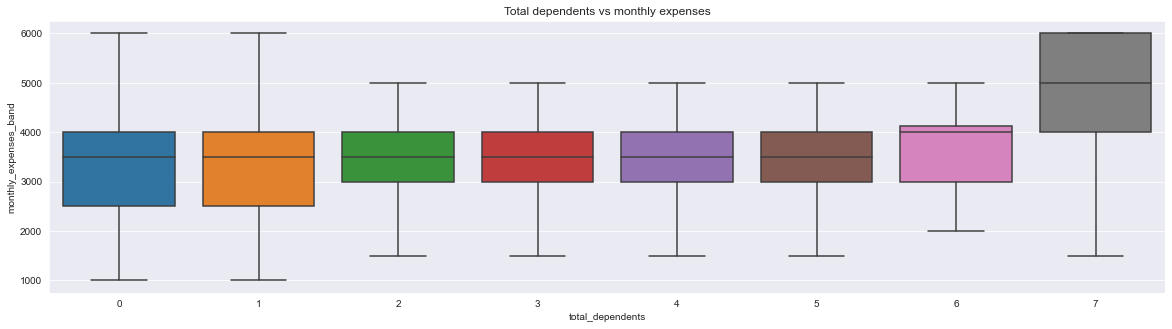

In [52]:
df['total_dependents']=0
df_clean['total_dependents']=0

df['total_dependents'] = df.old_dependents + df.young_dependents 
df_clean['total_dependents'] = df.old_dependents + df.young_dependents
ph.customize_box_plot(df=df_clean,
                         y='monthly_expenses_band', 
                         x='total_dependents', 
                         title='Total dependents vs monthly expenses',
                         showfliers=False)

In [53]:
hp.count_percentage_mode(df_clean, "total_dependents","monthly_expenses_band")

,count,percentage,mode
total_dependents,,,
0,13231,0.345565,3000
1,10075,0.263137,4000
2,11014,0.287662,4000
3,3206,0.083734,4000
4,644,0.016820,4000
5,93,0.002429,4000
6,20,0.000522,4000
7,5,0.000131,6000


* In spite of number of dependends being more (6) the monthly expenses is almost same as applicant with less dependents, May own the house 


In [54]:
hp.count_percentage_mode(df_clean, "occupants_count","max_loan_amount")

,count,percentage,mode
occupants_count,,,
0,5097,0.133123,5000
1,2414,0.063048,5000
2,9278,0.242321,10000
3,8277,0.216177,8000
4,9798,0.255903,8000
5,2631,0.068716,5000
6,575,0.015018,5000
7,119,0.003108,5000
8,45,0.001175,5000


**occupants_count** more than 15 is not realistic will be imputing the data with **total_dependents** + 1(Applicant)

In [55]:
df_clean.loc[(df_clean.occupants_count > 10) & (df_clean.occupants_count <= 12), 'occupants_count'] = 10
df_clean.loc[(df_clean.occupants_count > 15), 'occupants_count'] = df_clean['total_dependents'] + 1

In [56]:
hp.count_percentage_mean(df_clean, "occupants_count","max_loan_amount")

,count,percentage,mean
occupants_count,,,
0,5097,0.133123,5082.597606
1,2415,0.063075,8303.519669
2,9282,0.242426,8388.386124
3,8284,0.216360,8514.485756
4,9799,0.255929,8580.059190
5,2631,0.068716,7690.611935
6,576,0.015044,6890.625000
7,119,0.003108,6983.193277
8,45,0.001175,7222.222222


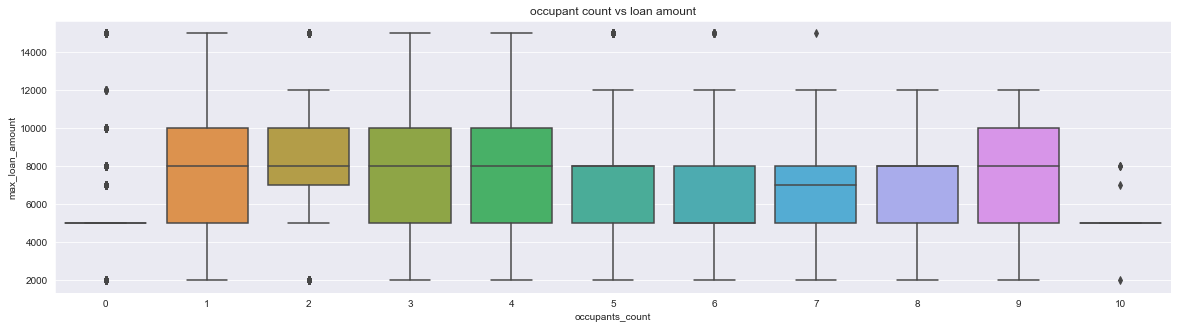

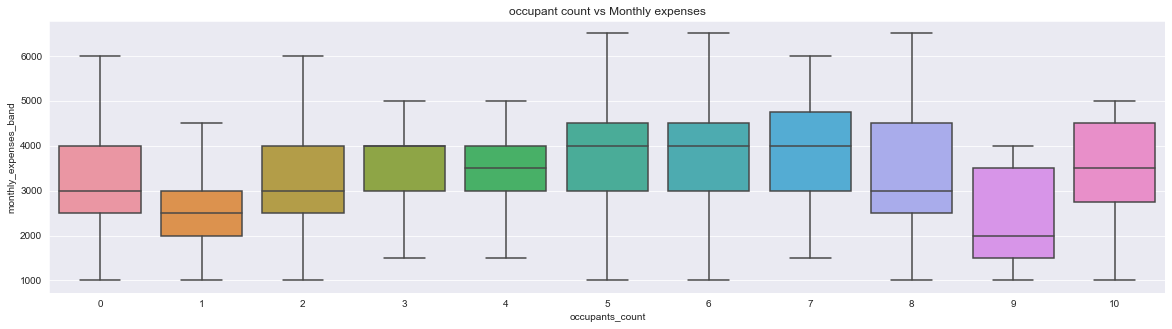

In [57]:
ph.customize_box_plot(df=df_clean,
                     y='max_loan_amount', 
                     x='occupants_count', 
                     title='occupant count vs loan amount')

ph.customize_box_plot(df=df_clean,
                     y='monthly_expenses_band', 
                     x='occupants_count', 
                     title='occupant count vs Monthly expenses',
                     showfliers=False)

In [58]:
hp.count_percentage_mode(df_clean, "occupants_count","monthly_expenses_band")

,count,percentage,mode
occupants_count,,,
0,5097,0.133123,3000
1,2415,0.063075,3000
2,9282,0.242426,3000
3,8284,0.216360,4000
4,9799,0.255929,4000
5,2631,0.068716,4000
6,576,0.015044,4000
7,119,0.003108,4000
8,45,0.001175,3000


* As occupant count increases loan amount approved is less except for the 0 occupant count
* Around 75% of the applicant have less than 4 occupants. 
* There is no signifant relationship between occupant count and monthly expenses. 
* Applicant has declared occupant count as 0. whats thier dependent_count?

In [59]:
print("Occupant count is 0: ", df_clean[df_clean['occupants_count'] == 0].shape[0])
print ("Occupant count, dependent count is 0: ", df_clean[(df_clean['occupants_count'] == 0) & (df_clean['total_dependents'] == 0)].shape[0]) 


Occupant count is 0:  5097
Occupant count, dependent count is 0:  5090


`occupants_count` can't be 0 atleast the applicant should be the occupant. Imputing the occupant count as  total_dependends + 1

In [60]:
df_clean.loc[(df_clean.occupants_count == 0), 'occupants_count'] = df_clean['total_dependents']+1

### Predictor variable `house_area`

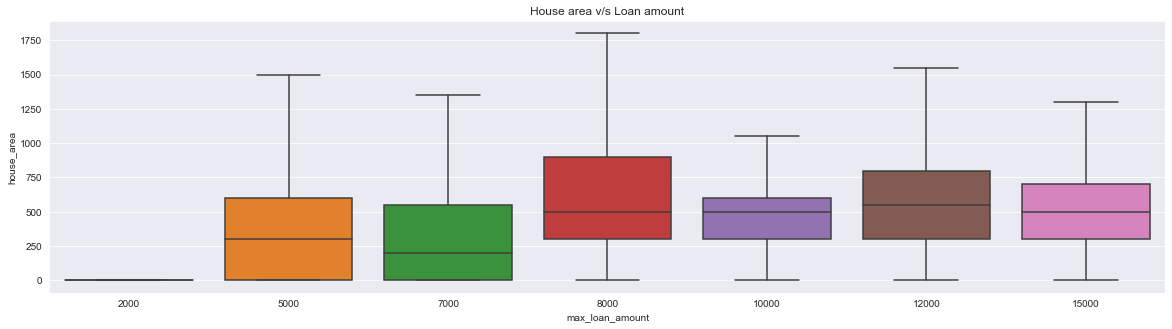

Maximum house area: 700000.0
Minimum house area: 0.0
Mean house area:552.80


In [61]:
ph.customize_box_plot(df=df_clean, 
                       y='house_area',
                       x='max_loan_amount',
                       title='House area v/s Loan amount',
                       showfliers=False)
print('Maximum house area:', df.house_area.max())
print('Minimum house area:', df.house_area.min())
print("Mean house area:" + "{:.2f}".format(df.house_area.mean()))

Assuming **house_area** in sqft most of the applicant house area is below 1800 sqrt Binning the values to form discrete data point

In [62]:
df_clean['house_area_band']=0
df_clean.loc[df_clean.house_area == 0, 'house_area_band'] = 0
df_clean.loc[(df_clean.house_area > 0) & (df_clean.house_area <= 500), 'house_area_band'] = 1
df_clean.loc[(df_clean.house_area > 500) & (df_clean.house_area <= 1000), 'house_area_band'] = 2
df_clean.loc[(df_clean.house_area > 1000) & (df_clean.house_area <= 1500), 'house_area_band'] = 3
df_clean.loc[(df_clean.house_area > 1500) & (df_clean.house_area <= 2000), 'house_area_band'] = 4
df_clean.loc[(df_clean.house_area > 2000) & (df_clean.house_area <= 2500), 'house_area_band'] = 5
df_clean.loc[df_clean.house_area > 2500, 'house_area_band'] = 6

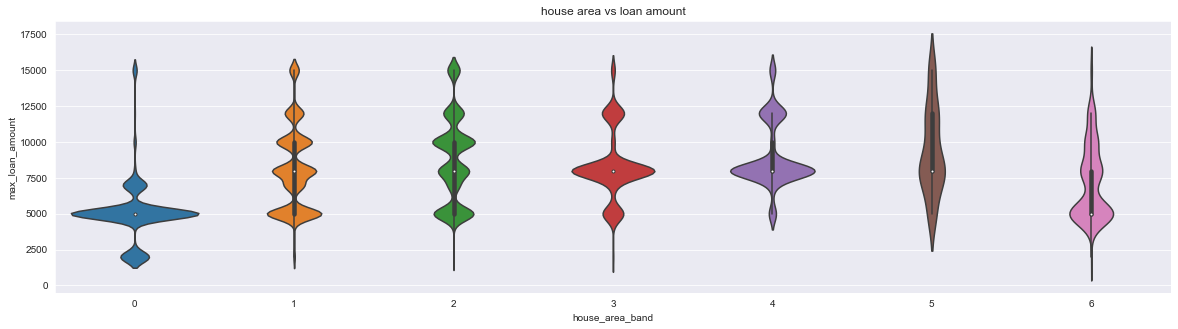

,count,percentage,mode
house_area_band,,,
0,5024,0.131216,5000
1,18731,0.489213,5000
2,11292,0.294923,10000
3,1717,0.044844,8000
4,1163,0.030375,8000
5,68,0.001776,8000
6,293,0.007653,5000


In [63]:
ph.customize_violin_plot(df=df_clean,
                     y='max_loan_amount', 
                     x='house_area_band', 
                     title='house area vs loan amount')

hp.count_percentage_mode(df_clean, "house_area_band","max_loan_amount")

**house_area_band** indicates that applicants with less than 500 sqft **house_area** most like to get loan amount approved as 5000. 

Higher the house area loan amount approved seems higher.


### Predictor variable `home_ownership`

In [64]:
hp.count_percentage_mode(df_clean, "home_ownership","max_loan_amount")

,count,percentage,mode
home_ownership,,,
0.0,896,0.023402,5000
1.0,37038,0.967353,5000


96% of ther applicants own thier house. **home_ownership** is missing for few applicants(**Data imputations!**)

Is there a relationship between **home_ownership** and monthly expenses?

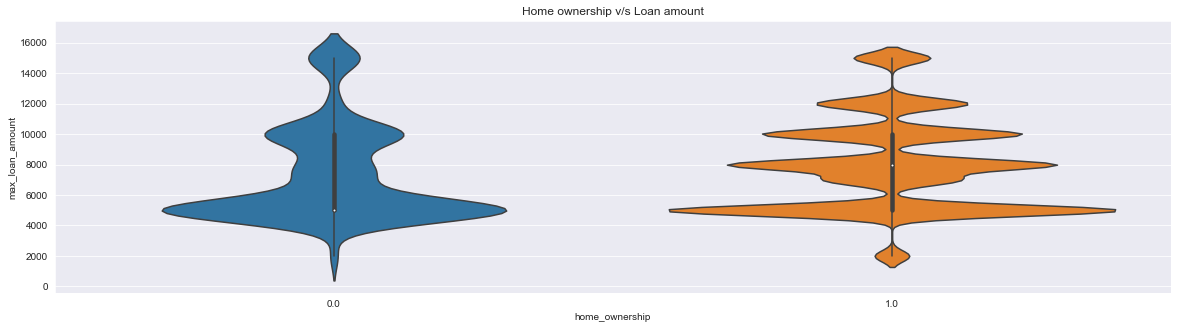

In [65]:
ph.customize_violin_plot(df_clean, 
                   y='max_loan_amount',
                   x='home_ownership',
                   title='Home ownership v/s Loan amount')

More applicant with house likely to get loan amount between 7K to 12k compare to without house

What is the effect of house_ownership on monthly expenses?

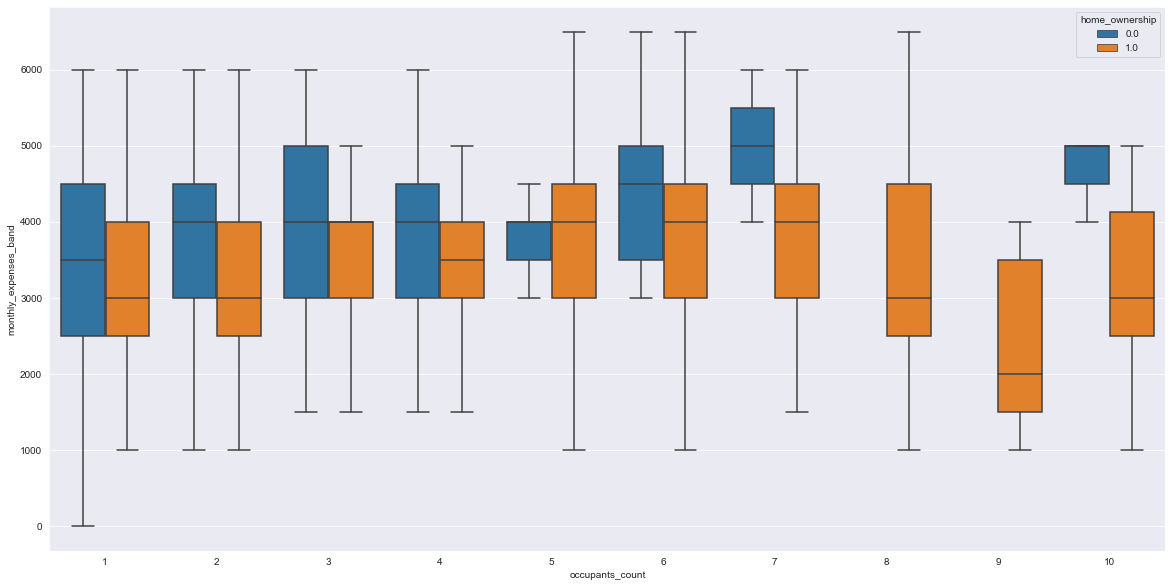

,count,percentage,mode
home_ownership,,,
0.0,896,0.023402,4000
1.0,37038,0.967353,4000


In [66]:
ph.customize_box_plot(df = df_clean, 
                      y = 'monthly_expenses_band',
                      x = 'occupants_count',
                      hue = 'home_ownership',
                      showfliers= False,
                      height=10)

hp.count_percentage_mode(df_clean, "home_ownership","monthly_expenses_band")

* Applicant with occupant count more than 7 likely to own thier house.
* For the applicants who own house has monthly expenses less than who don't.
* This could be the reason for the applicants with more occupants with less monthly expenses.
* House area is 0 then applicant can't own thier house, missing value for house_owership as house_area as 0. Imputing the home_ownership as 0




In [67]:
df_clean.loc[(df_clean['home_ownership'].isnull()) & (df_clean['house_area'] == 0), 'home_ownership'] = 0

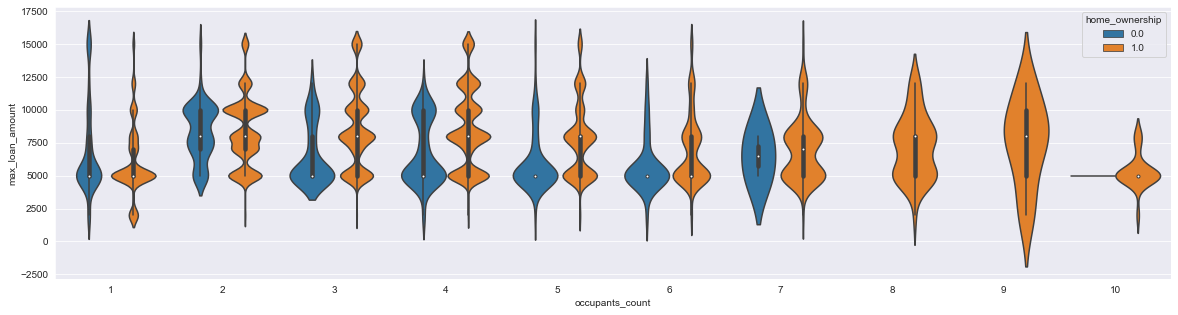

In [68]:
ph.customize_violin_plot(df=df_clean,
                         x="occupants_count", 
                         y="max_loan_amount", 
                         hue="home_ownership")

It is evident that higher the occupants count,  applicants own thier house

### Predictor variable `age`

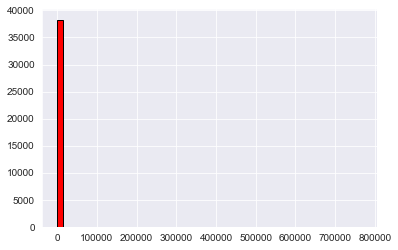

In [69]:
df_clean.age.hist(bins=50,
            edgecolor='black',
            color='red')
plt.show()

There is some unrealistic age which is more than 100. Any age lower than 18 and more than 60 is not eligible for loan.

Dropping the data points for age > 60 and age < 18


In [70]:
df_clean = df_clean.drop(df_clean[df_clean['age'] > 60].index)
df_clean = df_clean.drop(df_clean[df_clean['age'] < 18].index)

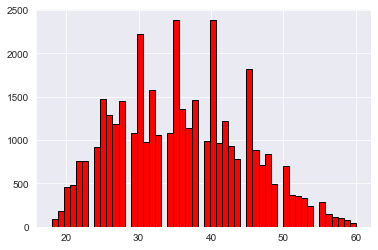

Oldest Applicant: 60 Years
Youngest Applicant : 18 Years
Average Age of the Applicant:35.89 Years


In [71]:
df_clean.age.hist(bins=50,
            edgecolor='black',
            color='red')
plt.show()

# Continous feature - Age
print('Oldest Applicant:', df_clean.age.max(), 'Years')
print('Youngest Applicant :', df_clean.age.min(), 'Years')
print("Average Age of the Applicant:" + "{:.2f}".format(df_clean.age.mean()), 'Years')

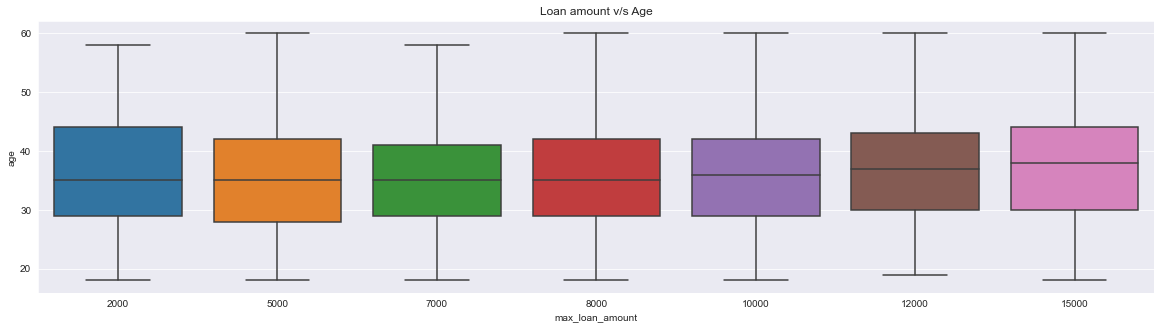

In [72]:
ph.customize_box_plot(df=df_clean, 
                        x='max_loan_amount',
                        y='age',
                        title='Loan amount v/s Age')

**age** is modertely skewed. Binning age to form discrete variable

In [73]:
df_clean['age_band']=0
df_clean.loc[(df_clean.age >= 18) & (df_clean.age <= 25), 'age_band'] = 1
df_clean.loc[(df_clean.age > 25) & (df_clean.age <= 30), 'age_band'] = 2
df_clean.loc[(df_clean.age > 30) & (df_clean.age <= 35), 'age_band'] = 3
df_clean.loc[(df_clean.age > 35) & (df_clean.age <= 40), 'age_band'] = 4
df_clean.loc[(df_clean.age > 40) & (df_clean.age <= 45), 'age_band'] = 5
df_clean.loc[(df_clean.age > 45) & (df_clean.age <= 50), 'age_band'] = 6
df_clean.loc[(df_clean.age > 50) & (df_clean.age <= 55), 'age_band'] = 7
df_clean.loc[df_clean.age > 55, 'age_band'] = 8

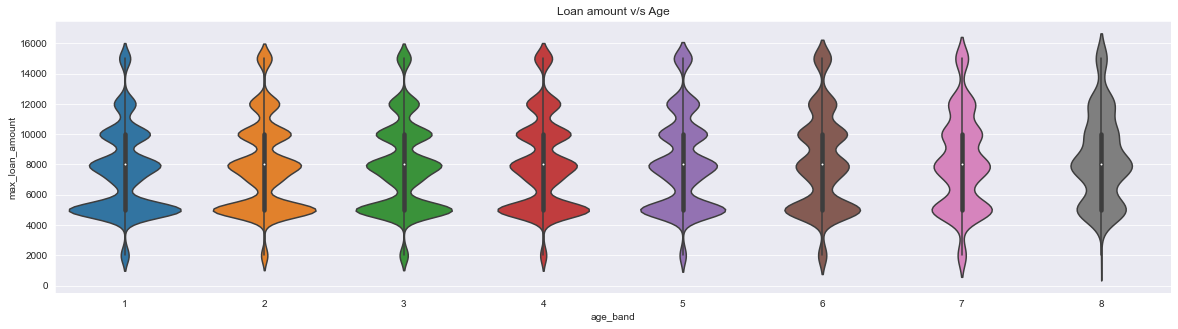

In [74]:
ph.customize_violin_plot(df=df_clean, 
                        y='max_loan_amount',
                        x='age_band',
                        title='Loan amount v/s Age')

In [75]:
hp.count_percentage(df_clean, 'age_band')

,count,percentage
age_band,,
1,5114,0.133973
2,7238,0.189615
3,7088,0.185686
4,7321,0.191790
5,5708,0.149534
6,3630,0.095096
7,1587,0.041575
8,486,0.012732


There are less than 15% of applicants who are older than 45 years

### Predictor variable `city`, `social_class` has missing data.

* city column will be dropped as it is hard to impute the data and how much this variable can contribute? can't be determined for sure.
* Social class will be of important in case of government loan. Missing values are assigned as Others.   

In [76]:
# City 
df['city'] = df['city'].fillna('Unknow')
df_clean['city'] = df_clean['city'].fillna('Unknow')

In [77]:
# Social class 

def clean_social_class(df):
    
    df['social_class'] = df['social_class'].fillna('NOT-REVEALED')
    # Number in the social class can be imputed to not-revealed    
    df.loc[df['social_class'].str.isnumeric(), 'social_class'] = 'NOT-REVEALED'
    df['social_class'] = df['social_class'].str.upper() 
    df['social_class'] = df['social_class'].str.replace('.','')
    df['social_class'] = df['social_class'].str.replace('NIL','NOT-REVEALED')
    df['social_class'] = df['social_class'].str.replace('OPEN','NOT-REVEALED')
    df['social_class'] = df['social_class'].str.replace('NOT AVAILABLE','NOT-REVEALED')

    # There are misspelled cast

    df['social_class'].replace(['SECHUDLE CASTE','SCHUDLE CAST','SCHEDULED CASTE','S C','SCHDULED CAST','HINDU_SC',
                           'SECHUDLE CAST','HARIJAN_SC','SCEDELT CAST','CHAMBHAR-SC','STSC','SCHEDULE CASTE',
                           'ADI KARNATAKA (SC)','STC','SECHUDLED CASTE','MAHAR(SC)','SS',
                           'SECHUDLE TRIPE', 'SCHEDULED TRIBE', 'TRIBAL', 'TRIBEL', 'S T', 'DHANGAR(NOMADIC TRIBE)','DHANGAR(NOMADIC TRIBES)','ST GOND','ST(HARIJAN)'],
                          ['SC','SC','SC','SC','SC','SC','SC','SC','SC','SC','SC','SC','SC','SC','SC','SC','SC''ST','ST','ST','ST','ST','ST','ST','ST','ST','ST'],
                          inplace=True)
    df['social_class'].replace(['GENERAL','GC','GEN','HINDU','GENERAL CASTE','GENL','GENAREL','GENARAL','HINDHU','GENRAL',
                               'GENREL','TELAGU','TAMIL','MADRASI','24 TELUGASHETTY','TELGU','GENAREL CAST','GN','GRN','HINDU, WADDAR',
                               'GENETAL','G','GEBERAL','GEN- BPL'],
                          'GC',
                          inplace=True)

    df['social_class'].replace(['KASAR- OBC','OTHER BACKWARD CASTE','HINDU_OBC','HINDU, KURUBA','0BC','SONAR (OBC)',
                                'OC','OBC`','OGC','O B C','ABC','SBC','OBC','2ND','O'],
                          'OBC',
                          inplace=True)

    df['social_class'].replace(['MUSHLIM','MUSLIM','MUSILIM','ISLAM','MUSILM'],
                               'MUSLIM'
                               ,inplace=True)

    df['social_class'].replace(['CRISTAN','CHRISTAIN','CHRICSHAN'],
                               'CHRISTIAN'
                               ,inplace=True)

    df['social_class'].replace(['MINORITY','MINORITY COMUNITY','MYNORITY',
                               'MYNIRITY','MIONRITY','MINERTY','MYNORETY','MAINOLITY'],
                               'MINORITY'
                               ,inplace=True)

    df['social_class'].replace(['MINORITY','CHRISTIAN','MUSLIM'],
                               'OBC'
                               ,inplace=True)

    df['social_class'].replace(['SC','ST'],
                               'BC'
                               ,inplace=True)

    allowed_vals = ['BC','OBC','GC','NOT-REVEALED']
    df.loc[~df['social_class'].isin(allowed_vals), 'social_class'] = 'OTHERS'
    return df

df_clean = clean_social_class(df_clean)
hp.count_percentage_mode(df_clean, "social_class","max_loan_amount")


,count,percentage,mode
social_class,,,
BC,9587,0.251153,5000
GC,5996,0.157078,5000
NOT-REVEALED,5335,0.139762,5000
OBC,14398,0.377187,8000
OTHERS,2856,0.074819,10000


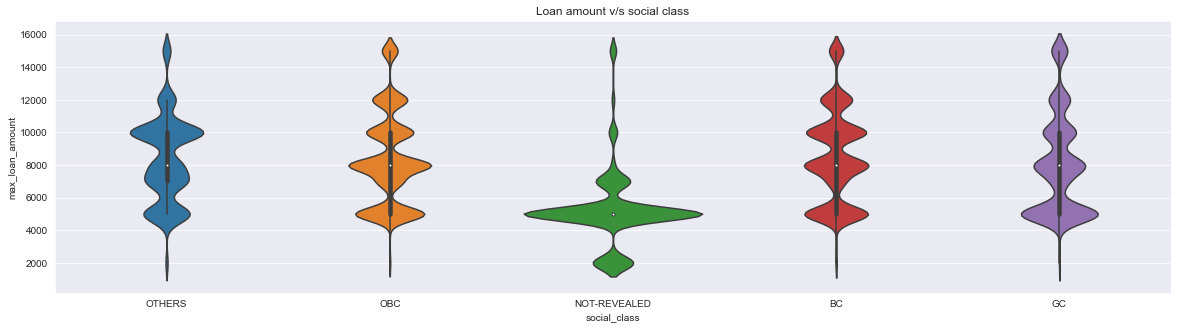

In [78]:
ph.customize_violin_plot(df=df_clean, 
                        y='max_loan_amount',
                        x='social_class',
                        title='Loan amount v/s social class')

Applicant who has not revealed thier social_class less likely to get higher loan amount approved

### Predictor Variable `sex`

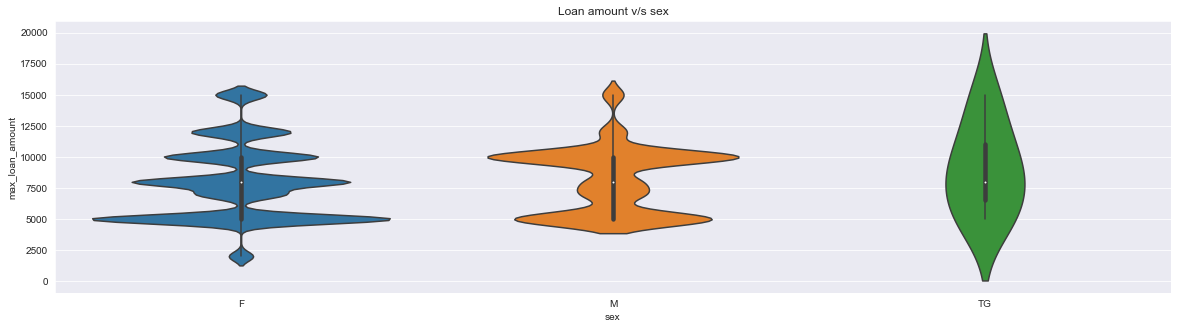

,count,percentage,mode
sex,,,
F,35925,0.941135,40000
M,2240,0.058682,50000
TG,7,0.000183,20000


In [79]:
ph.customize_violin_plot(df=df_clean, 
                   y='max_loan_amount',
                   x='sex',
                   title='Loan amount v/s sex')
hp.count_percentage_mode(df_clean, "sex","annual_income_band")

* More than 94% of the applicants are female. Average annual income for female is less than of Male
* Males are most likely to get loan amount 10000 approved than female

### Predictor variable `type_of_house`

In [80]:
hp.count_percentage_mode(df_clean, "type_of_house","max_loan_amount")

,count,percentage,mode
type_of_house,,,
R,5741,0.150398,5000
T1,14466,0.378969,5000
T2,17286,0.452845,5000


**Type of house** 
1. R - Room
2. T1 - Studio apartments
3. T2 - One bedroom

Is there a relationship between home_ownership, type_of_house and water/sanitary availability?

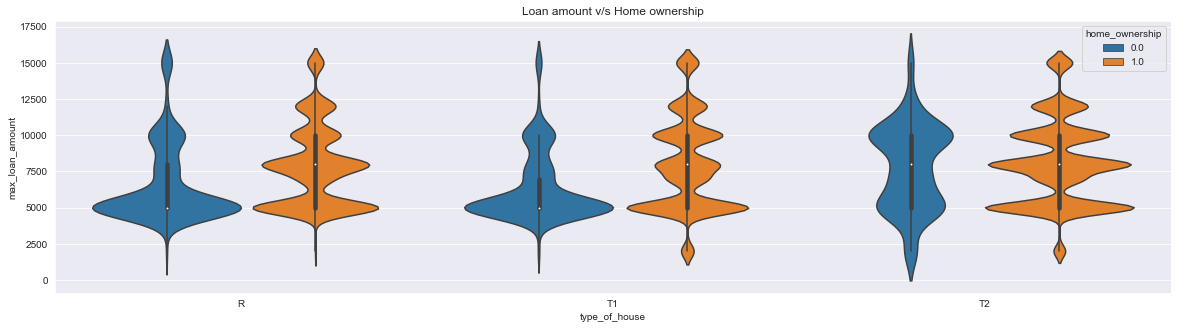

In [81]:
ph.customize_violin_plot(df=df_clean, 
                   y='max_loan_amount',
                   x='type_of_house',
                   hue='home_ownership',
                   title='Loan amount v/s Home ownership')

In [82]:
ph.customize_cross_tab([df.sanitary_availability,
            df.water_availability, df.type_of_house],[df.home_ownership])

* Owned houses are mostly T1(37%) or T2(44%)
* There is no house owned with sanitary but no water
* Applicant owns the home without both water and sanitary availability
* Among the applicant who don't have sanitary availability own house
* Most of owned houses has either half or full water availability
* If there is water most like that sanitary is available
* T2 house type applicants even though they don't own the house more likely to get loan amount 10K than other type of house 


Is there a relationship between house_onwership , type_of_house and house_area_band cross tab

In [83]:
ph.customize_cross_tab([df_clean.home_ownership,
            df_clean.type_of_house],
            [df_clean.house_area_band])

If the **house_area** is more than 1000 its likely that they own the house 

## Data Imputation

**sanitary_availability** based on the house_area mode of the data in imputed

In [84]:
df_clean.loc[(df_clean['sanitary_availability'].isnull()) & (df_clean['house_area'] == 0), 
             'sanitary_availability']=df_clean[(df_clean['house_area'] == 0)].sanitary_availability.mode()[0]

df_clean.loc[(df_clean['sanitary_availability'].isnull()) & (df_clean['house_area_band'] == 1), 
             'sanitary_availability']=df_clean[(df_clean['house_area_band'] == 1)].sanitary_availability.mode()[0]

**type_of_house** by its mode

In [85]:
print("Over all missing values for type_of_house:", df_clean[df_clean['type_of_house'].isnull()].shape[0])
print("Missing values of type_of_house where no sanitary and house is not owned: ", 
      df_clean[(df_clean['type_of_house'].isnull()) & (df_clean['sanitary_availability'] == 0) & (df_clean['home_ownership']==0)].shape[0]) 
print("Missing values of type_of_house where no sanitary and house is owned:", 
df_clean[(df_clean['type_of_house'].isnull()) & (df_clean['sanitary_availability'] == 0) & (df_clean['home_ownership']==1)].shape[0])

print("Missing values of type_of_house where with sanitary and house is owned:", 
df_clean[(df_clean['type_of_house'].isnull()) & (df_clean['sanitary_availability'] == 1) & (df_clean['home_ownership']==1)].shape[0])



Over all missing values for type_of_house: 679
Missing values of type_of_house where no sanitary and house is not owned:  303
Missing values of type_of_house where no sanitary and house is owned: 375
Missing values of type_of_house where with sanitary and house is owned: 1


In [86]:
def clean_type_of_house(df):
    df.loc[(df['type_of_house'].isnull()) & (df['sanitary_availability'] == 0) & (df['home_ownership']==0) ,
           'type_of_house'] =df[(df['sanitary_availability'] == 0) & (df['home_ownership']==0)].type_of_house.mode()[0]
    df.loc[(df['type_of_house'].isnull()) & (df['sanitary_availability'] == 0) & (df['home_ownership']==1) ,
           'type_of_house'] =df[(df['sanitary_availability'] == 0) & (df['home_ownership']==1)].type_of_house.mode()[0]
    df.loc[(df['type_of_house'].isnull()) & (df['sanitary_availability'] == 1) & (df['home_ownership']==1) ,
           'type_of_house'] =df[(df['sanitary_availability'] == 1) & (df['home_ownership']==1)].type_of_house.mode()[0]   
    return df

df_clean = clean_type_of_house(df_clean)

**water_availability**, If they applicant owns house then most likely to have water availability wither full or half taking the mode of the water avaibility

In [87]:
def clean_water_availability(df):
    df.loc[(df['water_availability'].isnull()) & (df['sanitary_availability'] == 0) & (df['home_ownership']==0), 
       'water_availability'] = df[(df['sanitary_availability'] == 0) & (df['home_ownership']==0)].water_availability.mode()[0]

    df.loc[(df['water_availability'].isnull()) & (df['sanitary_availability'] == 0) & (df['home_ownership']==1), 
       'water_availability'] = df[(df['sanitary_availability'] == 0) & (df['home_ownership']==1)].water_availability.mode()[0]
    
    df.loc[(df['water_availability'].isnull()) & (df['sanitary_availability'] == 1) & (df['home_ownership']==1), 
       'water_availability'] = df[(df['sanitary_availability'] == 1) & (df['home_ownership']==1)].water_availability.mode()[0]
    
    return df

df_clean = clean_water_availability(df_clean)

**monthly_expenses**

* Monthly expenses are higher for applicant who don't own house
* Monthly expenses are less for T2 types of house as most of the T2 houses are owned 
* Higher the occupant count more the monthly expenses
* Filling the missing values with mode of the monthly expenses 

In [88]:
for count in range(1,11,1):
    df_clean.loc[(df_clean['monthly_expenses_band'].isnull()) & (df_clean['occupants_count'] == count), 
           'monthly_expenses_band'] = df_clean[(~df_clean['monthly_expenses_band'].isnull()) & (df_clean['occupants_count'] == count)].monthly_expenses_band.mode()[0]

In [89]:
df_clean['primary_business_clean'] = df_clean['primary_business_clean'].str.replace('\s+', '_')
df_clean['loan_purpose'] = df_clean['loan_purpose'].str.replace('\s+', '_')

### Predictions

**----------------------------------------------------------------------------**

In [90]:
df = df_clean.drop(['city',
                         'age',
                          'primary_business',
                          'primary_business_clean',
                          'monthly_expenses',
                          'primary_business',
                          'loan_purpose',
                          'house_area',
                          'total_dependents'], 
                                     axis=1)
column_name = list(df.columns.values)

### Split train , test and validation set

In [91]:
hp.count_percentage(df, 'max_loan_amount')

,count,percentage
max_loan_amount,,
2000,938,0.024573
5000,12338,0.323221
7000,3528,0.092424
8000,8486,0.222310
10000,6875,0.180106
12000,3959,0.103715
15000,2048,0.053652


In [92]:
df = pd.get_dummies(df, 
                    columns=['type_of_house'], 
                    prefix = ['type_of_house'])
df = pd.get_dummies(df, 
                    columns=['social_class'], 
                    prefix = ['social_class'])
df = pd.get_dummies(df, 
                    columns=['sex'], 
                    prefix = ['sex'])

df = df.rename({"max_loan_amount": "label"}, axis=1)

In [93]:
y_true = df['label'].values

X_train, test_df, y_train, y_test = train_test_split(df, y_true, stratify = y_true, test_size=0.2)
train_df, cv_df, y_train, y_cv = train_test_split(X_train,y_train,stratify = y_train, test_size=0.2 )

print('Data points in train data:', train_df.shape[0])
print('Data points in test data:', test_df.shape[0])
print('Data points in cross validation data:', cv_df.shape[0])

train_df_onehotencode = train_df
cv_df_onehotencode = cv_df
test_df_onehotencode = test_df

train_y = np.array(list(train_df['label']))
test_y = np.array(list(test_df['label']))
cv_y = np.array(list(cv_df['label']))

Data points in train data: 24429
Data points in test data: 7635
Data points in cross validation data: 6108


### Distribution of classes in data split

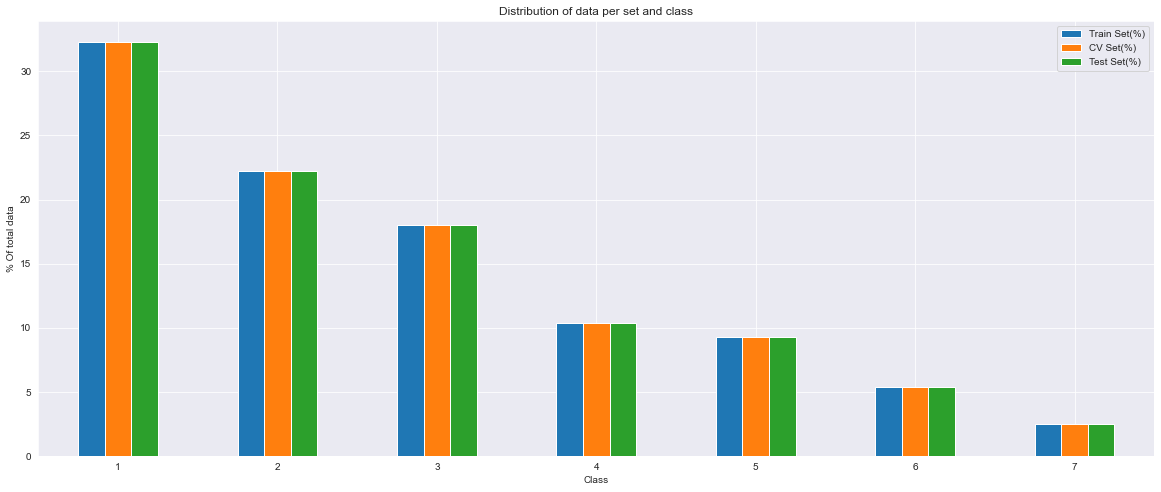

In [94]:
ph.multi_class_dist(train_df, test_df, cv_df, 'label')

### Base line error

In [95]:
w_mat = np.zeros([7, 7], dtype=np.float)
for i in range(len(w_mat)):
    for j in range(len(w_mat)):
        if i < j:
            w_mat[i][j] = 3

for i in range(len(w_mat)):
    for j in range(len(w_mat)):
        if i > j:
            w_mat[i][j] = float(((i - j) ** 2) / 16)
            
df_weight = pd.DataFrame(w_mat)
df_weight.index = [2000, 5000, 7000, 8000, 10000, 12000, 15000]
df_weight.columns = [2000, 5000, 7000, 8000, 10000, 12000, 15000]
df_weight

,2000,5000,7000,8000,10000,12000,15000
2000,0.0000,3.0000,3.0000,3.0000,3.0000,3.0000,3.0
5000,0.0625,0.0000,3.0000,3.0000,3.0000,3.0000,3.0
7000,0.2500,0.0625,0.0000,3.0000,3.0000,3.0000,3.0
8000,0.5625,0.2500,0.0625,0.0000,3.0000,3.0000,3.0
10000,1.0000,0.5625,0.2500,0.0625,0.0000,3.0000,3.0
12000,1.5625,1.0000,0.5625,0.2500,0.0625,0.0000,3.0
15000,2.2500,1.5625,1.0000,0.5625,0.2500,0.0625,0.0


In [96]:
labels = [2000, 5000, 7000, 8000, 10000, 12000, 15000]

test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]
cv_predicted_y = np.zeros((cv_data_len,7),dtype=int)
for i in range(cv_data_len):
    cv_predicted_y[i] = random.choice(labels)
    
cv_pred_y = np.amax(cv_predicted_y, axis=1)

cv_log_loss = round(log_loss(y_cv,cv_predicted_y, eps=1e-15),2)
cv_weighted_loss = ch.custom_weighted_loss(y_cv, cv_pred_y)
print("log loss on Cross Validation Data using Random Model",cv_log_loss)
print("Weighted loss on Cross Validation Data using Random Model",cv_weighted_loss)

test_predicted_y = np.zeros((test_data_len,7),dtype=int)
for i in range(test_data_len):
    test_predicted_y[i] = random.choice(labels) 

test_pred_y = np.amax(test_predicted_y, axis=1)
test_log_loss = round(log_loss(y_test,test_predicted_y, eps=1e-15),2)
test_weighted_loss = ch.custom_weighted_loss(y_test, test_pred_y)
print("log loss on Test Data using Random Model",test_log_loss)
print("Weighted loss on Test Data using Random Model",test_weighted_loss)

predicted_y = np.amax(test_predicted_y, axis=1)

log loss on Cross Validation Data using Random Model 1.95
Weighted loss on Cross Validation Data using Random Model 1.1066941960460353
log loss on Test Data using Random Model 1.95
Weighted loss on Test Data using Random Model 1.1342782456334546


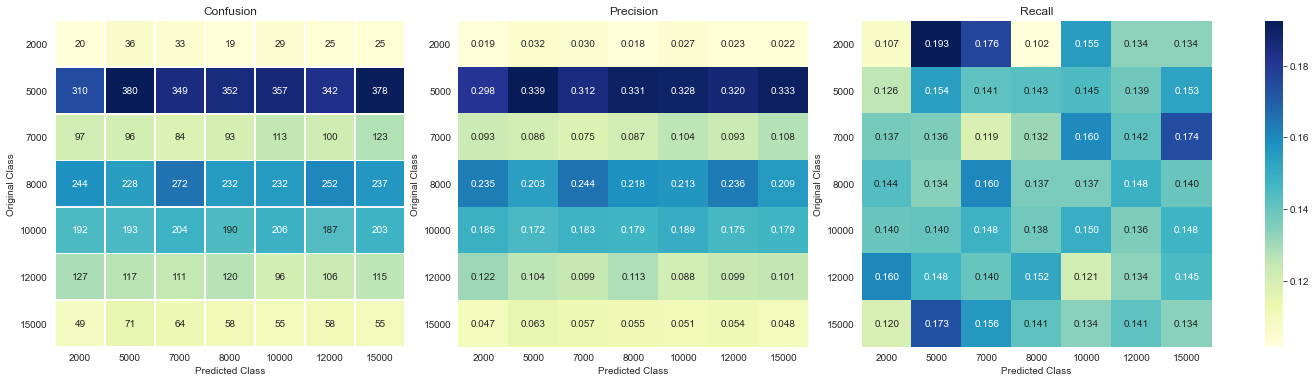

In [97]:
mh.plot_matrices(y_test,predicted_y,labels)

In [98]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier

In [99]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)
    mh.plot_matrices(test_y, pred_y, labels)
    


def model_performance(name, clf, best_alpha, train_X_hotencode, cv_X_hotencode, test_X_hotencode):
    clf = clf
    clf.fit(train_X_hotencode, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_X_hotencode, train_y)

    train_predict_y = sig_clf.predict_proba(train_X_hotencode)
    train_log_loss = np.round(log_loss(y_train, train_predict_y, labels=clf.classes_, eps=1e-15), 3)
    
    train_pred_y = ch.predict_from_probability(train_predict_y, labels)   
    train_weighted_error = ch.custom_weighted_loss(y_train, train_pred_y)

    cv_predict_y = sig_clf.predict_proba(cv_X_hotencode)
    cv_log_loss = np.round(log_loss(y_cv, cv_predict_y, labels=clf.classes_, eps=1e-15), 3)
    
    cv_pred_y = ch.predict_from_probability(cv_predict_y, labels)
    cv_weighted_error = ch.custom_weighted_loss(y_cv, cv_pred_y)
    
    test_predict_y = sig_clf.predict_proba(test_X_hotencode)
    test_log_loss = np.round(log_loss(y_test, test_predict_y, labels=clf.classes_, eps=1e-15), 3)
    
    
    test_pred_y = ch.predict_from_probability(test_predict_y, labels)
    test_weighted_error = ch.custom_weighted_loss(y_test, test_pred_y)

    pred_y = sig_clf.predict(test_X_hotencode)
    
    print('Precision: %.3f' % mh.precision(y_test, test_pred_y, labels))
    print('Recall: %.3f' % mh.recall(y_test, test_pred_y))
    print('F-Measure: %.3f' % mh.f1score(y_test, test_pred_y))
    

    miss_class = np.count_nonzero((pred_y - test_y)) / test_y.shape[0]

    report_log_loss = [name,
                       best_alpha,
                       train_log_loss,
                       cv_log_loss,
                       test_log_loss,
                       train_weighted_error,
                       cv_weighted_error,
                       test_weighted_error,
                       miss_class]

    temp_df = pd.DataFrame([report_log_loss],
                           columns=['Model', 
                                    'best alpha', 
                                    'train_log_loss', 
                                    'cv_log_loss', 
                                    'test_log_loss',
                                    'train_weighted_loss', 
                                    'cv_weighted_loss', 
                                    'test_weighted_loss',                                    
                                    'Miss_classified(%)'])
    return temp_df

## Model Evaluation

#### Naive Bayse

In [100]:
alpha = [10 ** x for x in range(-2, 7)]
cv_log_error_array = []
cv_weighted_error_array = []

for i in alpha:
    clf = MultinomialNB(alpha=i)
    clf.fit(train_df_onehotencode, train_y)
    sig_clf = CalibratedClassifierCV(clf, method='isotonic')
    sig_clf.fit(train_df_onehotencode, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_df_onehotencode)
    

    cv_pred_y = ch.predict_from_probability(sig_clf_probs, labels)
    cv_weighted_error_array.append(ch.custom_weighted_loss(y_cv, cv_pred_y))
    
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs,
                                      labels=clf.classes_,
                                      eps=1e-15))
    

temp_df = pd.DataFrame(data={'alpha':np.round(alpha,5),
                             'cv_log_error': np.round(cv_log_error_array,5),
                             'cv_weighted_error':np.round(cv_weighted_error_array,5)})
temp_df.sort_values(by = 'cv_weighted_error', ascending=True)       
    
    

,alpha,cv_log_error,cv_weighted_error
3,10.00,1.38379,0.46256
0,0.01,1.38381,0.46296
1,0.10,1.38381,0.46296
2,1.00,1.38381,0.46296
4,100.00,1.38355,0.46630
6,10000.00,1.37586,0.48330
5,1000.00,1.38276,0.48751
8,1000000.00,1.61271,0.49000
7,100000.00,1.45977,0.57000


In [101]:
best_alpha = 0.01

clf = MultinomialNB(alpha=best_alpha)

NB_report = model_performance('Naive Bayes',
                               clf,
                               best_alpha,
                               train_df_onehotencode,
                               cv_df_onehotencode,
                               test_df_onehotencode)

Precision: 0.432
Recall: 0.432
F-Measure: 0.432


In [102]:
NB_report

,Model,best alpha,train_log_loss,cv_log_loss,test_log_loss,train_weighted_loss,cv_weighted_loss,test_weighted_loss,Miss_classified(%)
0,Naive Bayes,0.01,1.595,1.599,1.594,0.411678,0.412143,0.410288,0.56778


Naive Bayse


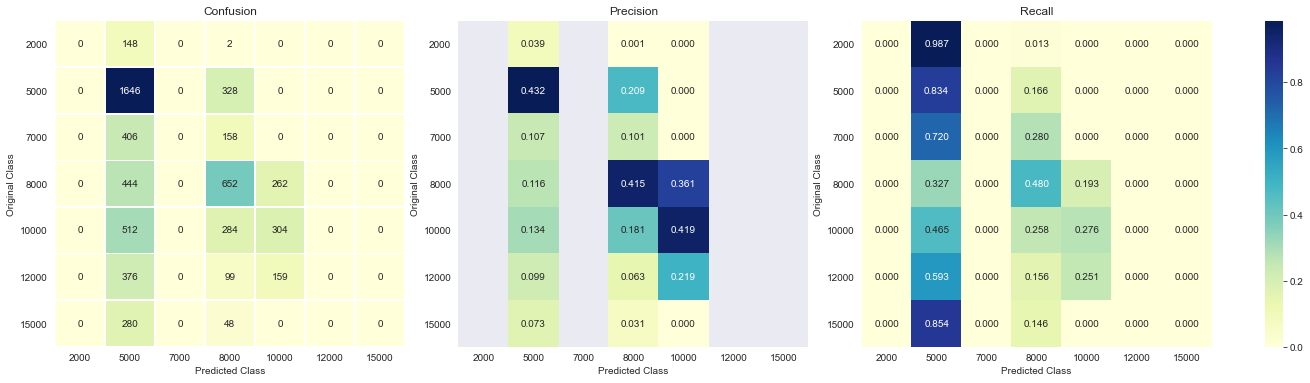

In [103]:
print ('Naive Bayse')
predict_and_plot_confusion_matrix(train_df_onehotencode, 
                                  train_y, 
                                  cv_df_onehotencode, 
                                  cv_y, 
                                  clf)

### Logistic Regression

In [104]:
alpha = [10 ** x for x in range(-3, 7)]
cv_log_error_array = []
cv_weighted_error_array = []

for i in alpha:
    clf = SGDClassifier(class_weight='balanced', 
                        alpha=i, 
                        penalty='l2', 
                        loss='log', 
                        random_state=42)
    
    clf.fit(train_df_onehotencode, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="isotonic")
    sig_clf.fit(train_df_onehotencode, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_df_onehotencode)
    
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    
    cv_pred_y = ch.predict_from_probability(sig_clf_probs, labels)
    cv_weighted_error_array.append(ch.custom_weighted_loss(y_cv, cv_pred_y))
    
    
temp_df = pd.DataFrame(data={'alpha': np.round(alpha,5), 
                             'cv_log_error': np.round(cv_log_error_array,5),
                             'cv_weighted_error': np.round(cv_weighted_error_array,5)})
temp_df.sort_values(by ='cv_weighted_error',ascending=True)

,alpha,cv_log_error,cv_weighted_error
5,100.000,1.17306,0.14241
2,0.100,1.19839,0.18813
4,10.000,1.16498,0.18928
6,1000.000,1.15363,0.19470
7,10000.000,1.09508,0.20119
9,1000000.000,1.12345,0.20248
8,100000.000,1.08196,0.20856
0,0.001,1.16302,0.30825
3,1.000,1.17348,0.32208
1,0.010,1.20425,0.33989


In [105]:
best_alpha = temp_df.loc[temp_df['cv_weighted_error'] == temp_df['cv_weighted_error'].min(), 'alpha'].item()

clf = SGDClassifier(class_weight='balanced', alpha=best_alpha, penalty='l2', loss='log', random_state=42)

LR_report = model_performance('Logistic Regression',
                             clf,
                             best_alpha,
                         train_df_onehotencode,
                         cv_df_onehotencode,
                         test_df_onehotencode)
LR_report

Precision: 0.501
Recall: 0.501
F-Measure: 0.501


,Model,best alpha,train_log_loss,cv_log_loss,test_log_loss,train_weighted_loss,cv_weighted_loss,test_weighted_loss,Miss_classified(%)
0,Logistic Regression,100.0,1.307,1.304,1.31,0.136529,0.132514,0.13296,0.499018


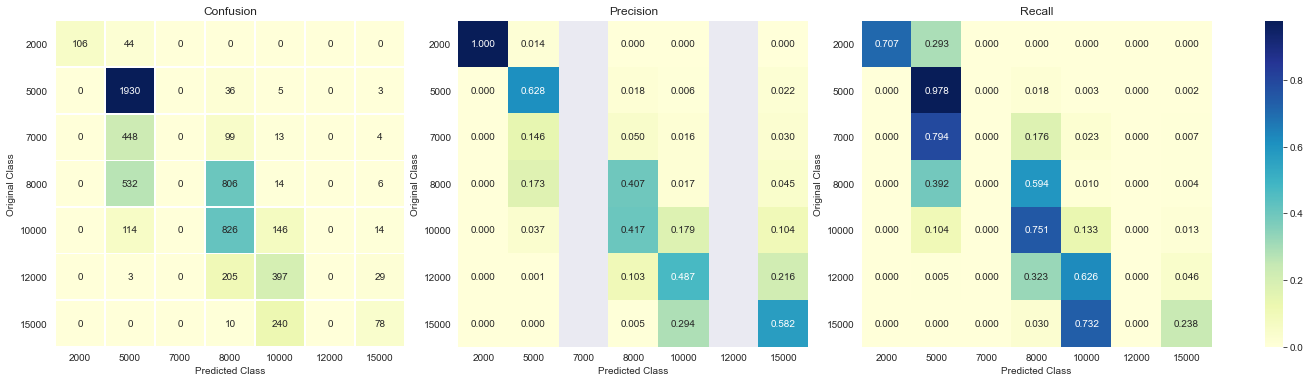

In [106]:
predict_and_plot_confusion_matrix(train_df_onehotencode, 
                                  train_y, 
                                  cv_df_onehotencode, 
                                  cv_y, clf)

### Logistic Regression without class balancing

In [107]:
alpha = [10 ** x for x in range(-2, 7)]
cv_log_error_array = []
cv_weighted_error_array = []

for i in alpha:
    clf = SGDClassifier(class_weight=None, alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_df_onehotencode, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="isotonic")
    sig_clf.fit(train_df_onehotencode, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_df_onehotencode)
    
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    cv_pred_y = ch.predict_from_probability(sig_clf_probs, labels)
    cv_weighted_error_array.append(ch.custom_weighted_loss(y_cv, cv_pred_y))
    
    
temp_df = pd.DataFrame(data={'alpha': np.round(alpha,5), 
                             'cv_log_error': np.round(cv_log_error_array,5),
                             'cv_weighted_error': np.round(cv_weighted_error_array,5)})
temp_df.sort_values(by ='cv_weighted_error',ascending=True)

,alpha,cv_log_error,cv_weighted_error
1,0.10,1.43148,0.11097
3,10.00,1.36986,0.11744
4,100.00,1.36890,0.16154
2,1.00,1.38230,0.16442
6,10000.00,1.33027,0.17112
5,1000.00,1.34883,0.17113
8,1000000.00,1.30389,0.19116
0,0.01,1.70552,0.21653
7,100000.00,1.33937,0.22002


In [108]:
best_alpha = temp_df.loc[temp_df['cv_weighted_error'] == temp_df['cv_weighted_error'].min(), 'alpha'].item()


clf = SGDClassifier(class_weight=None,alpha=best_alpha, penalty='l2', loss='log', random_state=42, )

LR_NoBal_report = model_performance('Logistic Regression (No Weight Balance)',
                             clf,
                             best_alpha,
                             train_df_onehotencode,
                             cv_df_onehotencode,
                             test_df_onehotencode)
LR_NoBal_report

Precision: 0.451
Recall: 0.451
F-Measure: 0.451


,Model,best alpha,train_log_loss,cv_log_loss,test_log_loss,train_weighted_loss,cv_weighted_loss,test_weighted_loss,Miss_classified(%)
0,Logistic Regression (No Weight Balance),0.1,1.432,1.431,1.433,0.111041,0.110975,0.106939,0.548788


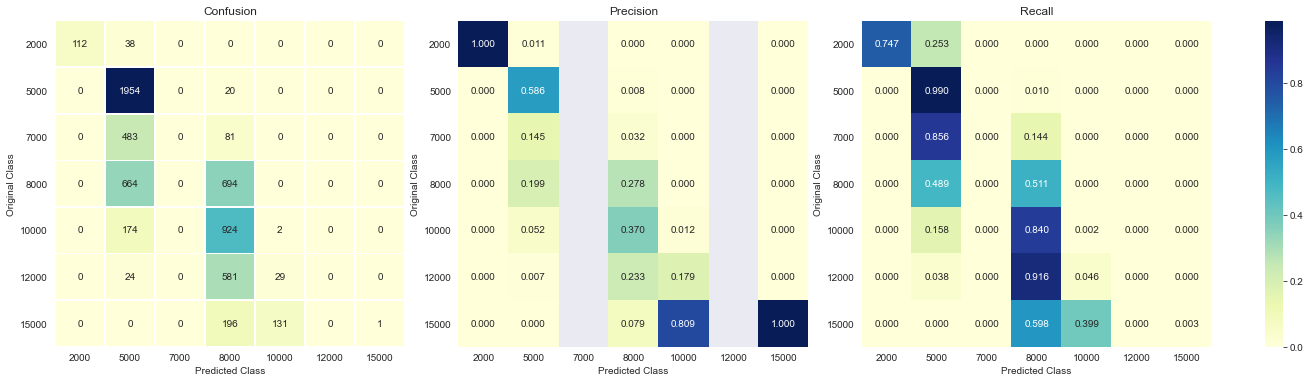

In [109]:
predict_and_plot_confusion_matrix(train_df_onehotencode,
                                  train_y,
                                  cv_df_onehotencode,
                                  cv_y, clf)

### Random forest

In [110]:
alpha = [100,200,500,1000,1500]
max_depth = [20, 50]

cv_log_error_array = []
cv_weighted_error_array = []

n_estimators=[]
depth=[]
for i in alpha:
    for j in max_depth:
        clf = RandomForestClassifier(n_estimators=i, 
                                     criterion='gini', 
                                     max_depth=j, 
                                     random_state=42, 
                                     n_jobs=-1)
        clf.fit(train_df_onehotencode, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_df_onehotencode, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_df_onehotencode)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        cv_pred_y = ch.predict_from_probability(sig_clf_probs, labels)
        cv_weighted_error_array.append(ch.custom_weighted_loss(y_cv, cv_pred_y))
        depth.append(j)
        n_estimators.append(i)
        
temp_df = pd.DataFrame(data={'n_estimators': np.round(n_estimators), 
                             'max_depth': np.round(depth),
                             'cv_log_error': np.round(cv_log_error_array,5),
                             'cv_weighted_error': np.round(cv_weighted_error_array,5)})
temp_df.sort_values(by ='cv_weighted_error',ascending=True)

,n_estimators,max_depth,cv_log_error,cv_weighted_error
2,200,20,0.00602,0.00007
0,100,20,0.00654,0.00008
3,200,50,0.00607,0.00008
4,500,20,0.00614,0.00008
5,500,50,0.00611,0.00008
6,1000,20,0.00620,0.00008
7,1000,50,0.00614,0.00008
8,1500,20,0.00618,0.00008
9,1500,50,0.00612,0.00008
1,100,50,0.00663,0.00043


In [111]:
best_estimator = 100
best_depth = 20
best_alpha ='n_estimators=',str(best_estimator),'max depth=',str(best_depth)
best_alpha

('n_estimators=', '100', 'max depth=', '20')

In [112]:
clf = RandomForestClassifier(n_estimators=best_estimator, 
                             max_depth=best_depth,
                             criterion='gini',
                             random_state=42,
                             n_jobs=-1)

RF_report = model_performance('Random Forest',
                             clf,
                             best_alpha,
                             train_df_onehotencode,
                             cv_df_onehotencode,
                             test_df_onehotencode)
RF_report

Precision: 0.999
Recall: 0.999
F-Measure: 0.999


,Model,best alpha,train_log_loss,cv_log_loss,test_log_loss,train_weighted_loss,cv_weighted_loss,test_weighted_loss,Miss_classified(%)
0,Random Forest,"(n_estimators=, 100, max depth=, 20)",0.002,0.007,0.004,0.0,0.000076,0.000315,0.000655


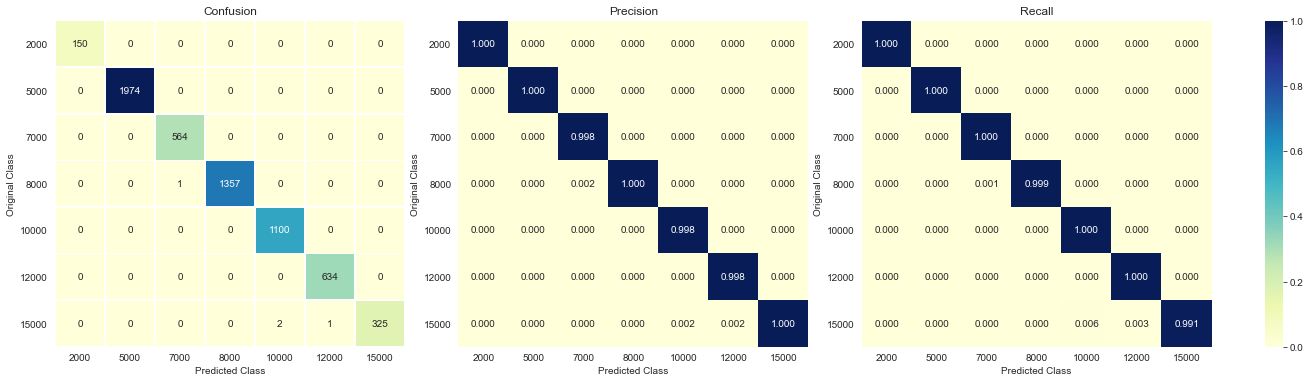

In [113]:
predict_and_plot_confusion_matrix(train_df_onehotencode, 
                                  train_y, 
                                  cv_df_onehotencode, cv_y, clf)

### Stacked model

In [114]:
# Naive Bayse
clf1 = MultinomialNB(alpha=0.1)
clf1.fit(train_df_onehotencode, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")
#Logistic Regression
clf2 = SGDClassifier(alpha=0.001, class_weight='balanced',  penalty='l2', loss='log', random_state=42)
clf2.fit(train_df_onehotencode, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")
# Random Forest
clf3 = RandomForestClassifier(n_estimators=best_estimator,max_depth=best_depth, criterion='gini',random_state=42,n_jobs=-1)
clf3.fit(train_df_onehotencode, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_df_onehotencode, train_y)
sig_clf2.fit(train_df_onehotencode, train_y)
sig_clf3.fit(train_df_onehotencode, train_y)

alpha = [0.0001,0.001,0.01,0.1,1,10] 
cv_log_error_array=[]
cv_weighted_error_array=[]
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_df_onehotencode, train_y)
    cv_log_error_array.append(log_loss(cv_y, sclf.predict_proba(cv_df_onehotencode)))
    
    cv_pred_y = ch.predict_from_probability(sclf.predict_proba(cv_df_onehotencode), labels)
    cv_weighted_error_array.append(ch.custom_weighted_loss(y_cv, cv_pred_y))
    
    
temp_df = pd.DataFrame(data={'alpha': np.round(alpha,5), 
                             'cv_log_error': np.round(cv_log_error_array,5),
                             'cv_weighted_error': np.round(cv_weighted_error_array,5)})
temp_df.sort_values(by ='cv_weighted_error',ascending=True)

,alpha,cv_log_error,cv_weighted_error
2,0.0100,0.10323,0.00008
3,0.1000,0.01795,0.00008
4,1.0000,0.00608,0.00008
5,10.0000,0.00522,0.00008
1,0.0010,0.57418,0.05605
0,0.0001,1.41295,0.20812


In [115]:
best_alpha = temp_df.loc[temp_df['cv_weighted_error'] == temp_df['cv_weighted_error'].min(), 'alpha'].min()

lr = LogisticRegression(C=best_alpha)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_df_onehotencode, train_y)

train_log_error = log_loss(train_y, sclf.predict_proba(train_df_onehotencode))
cv_log_error = log_loss(cv_y, sclf.predict_proba(cv_df_onehotencode))
test_log_error = log_loss(test_y, sclf.predict_proba(test_df_onehotencode))

miss_class = np.count_nonzero((sclf.predict(test_df_onehotencode)- test_y))/test_y.shape[0]

name = "Stacked (NB,LG,RF)"


report_log_loss=[name,
                     best_alpha,
                     train_log_error,
                     cv_log_error,
                     test_log_error,
                     miss_class]
    
stacked_report = pd.DataFrame([report_log_loss],columns=['Model','best alpha','train_log_loss','cv_log_loss','test_log_loss','Miss_classified(%)' ]) 
stacked_report

,Model,best alpha,train_log_loss,cv_log_loss,test_log_loss,Miss_classified(%)
0,"Stacked (NB,LG,RF)",0.01,0.099577,0.103225,0.101681,0.000655


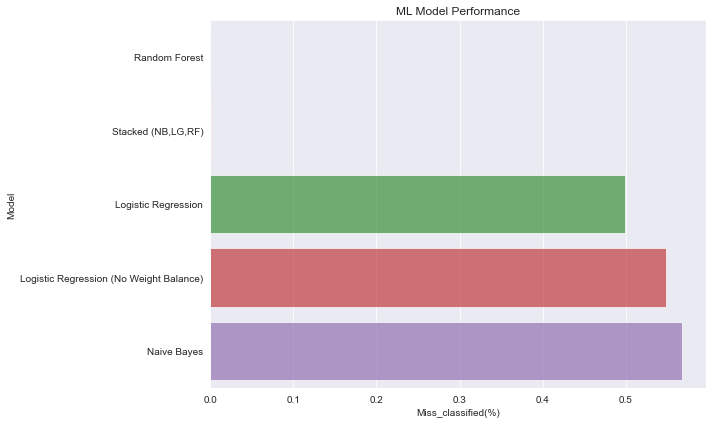

In [116]:
all_models = pd.concat([NB_report,
                        LR_report,
                        LR_NoBal_report,
                        RF_report,
                        stacked_report])

all_models = all_models.sort_values(by ='Miss_classified(%)',ascending=True)
# print(all_models.to_string())

plt.figure(figsize=(10,6))
sns.barplot(y='Model',x='Miss_classified(%)',data=all_models, alpha=0.7)
plt.title('ML Model Performance')
plt.tight_layout()

## Decision tree from  scratch 

In [117]:
from decisionTreeAlgorithm import decision_tree_algorithm
from randomForest import random_forest_algorithm
from utils import predict_example,calculate_r_squared,train_test_split,r_squared
from pprint import pprint

In [118]:
def random_forest_predictions(test_df, forest):
    df_predictions = {}
    for i in range(len(forest)):
        column_name = "tree_{}".format(i)
        predictions = decision_tree_predictions(test_df, tree=forest[i])
        df_predictions[column_name] = predictions

    df_predictions = pd.DataFrame(df_predictions)
    random_forest_predictions = df_predictions.mode(axis=1)[0]
    
    return random_forest_predictions

def decision_tree_predictions(test_df, tree):
    predictions = test_df.apply(predict_example, args=(tree,), axis=1)
    return predictions

def predict_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if comparison_operator == "<=":
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    # feature is categorical
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return predict_example(example, residual_tree)
    
def make_predictions(df, tree):
    if len(df) != 0:
        predictions = df.apply(predict_example,
                               args=(tree,),
                               axis=1)
    else:
        predictions = pd.Series()
    return predictions

In [119]:
def pred_model_metrics(y_true, test_df, tree):
    y_pred = make_predictions(test_df, tree)
    miss_class = np.count_nonzero((y_pred.values - y_true)) / y_true.shape[0]
    print('Miss_classified : %.4f' % miss_class)
    print('Weighted loss on Test Data: %.4f' % ch.custom_weighted_loss(y_true, y_pred.values))
    mh.plot_matrices(y_true, y_pred.values, labels)
    

In [120]:
cols = list(df.columns.values)
cols.pop(cols.index('label'))
df = df[cols+['label']]

train_df, val_df = train_test_split(df, test_size=0.4)
val_df, test_df = train_test_split(val_df,test_size=0.5)
y_test = test_df['label'].values
y_val = val_df['label'].values
y_train = train_df['label'].values

In [121]:
tree = decision_tree_algorithm(train_df, 
                               ml_task="classification", 
                               max_depth=50,
                               min_samples=2)

Miss_classified : 0.6767
Weighted loss on Test Data: 0.2317


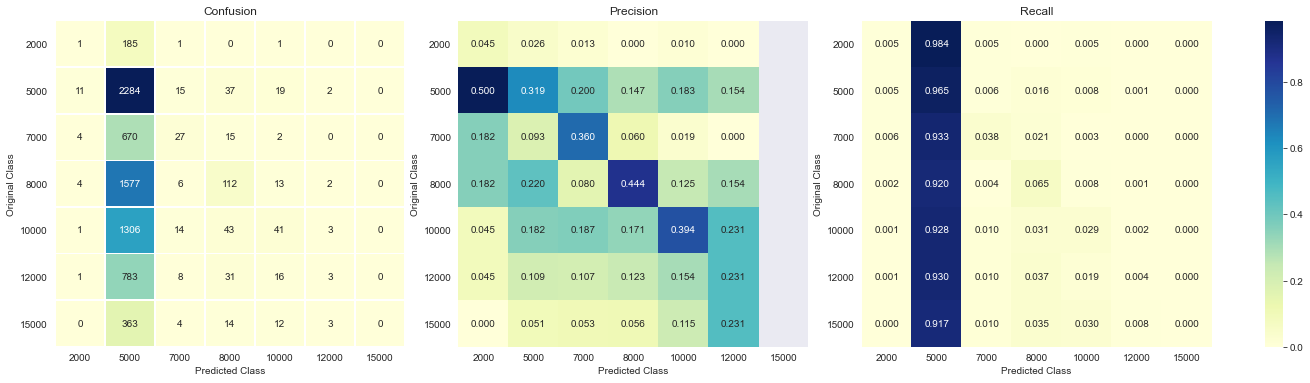

In [122]:
pred_model_metrics(y_test, test_df, tree)

## Random forest from scratch

In [123]:
grid_search = {"max_depth": [], 
               "min_samples": [],
               "n_features":[],
               "weighted_loss_train": [], 
               "weighted_loss_val": []}
for max_depth in range(20, 60, 20):
    for min_samples in range(30, 90, 30):
        for n_features in (4,6):
            forest = random_forest_algorithm(train_df, 
                                           ml_task="classification",
                                           n_trees=4, 
                                           n_bootstrap=16000,
                                           n_features=n_features,
                                           dt_max_depth=max_depth, 
                                           min_samples=min_samples)
            
            class_train = random_forest_predictions(train_df, forest)
            class_val = random_forest_predictions(val_df, forest)

            weighted_loss_train = ch.custom_weighted_loss(y_train, class_train)
            weighted_loss_val = ch.custom_weighted_loss(y_val, class_val)

            grid_search["max_depth"].append(max_depth)
            grid_search["min_samples"].append(min_samples)
            grid_search["n_features"].append(n_features)
            grid_search["weighted_loss_train"].append(weighted_loss_train)
            grid_search["weighted_loss_val"].append(weighted_loss_val)
        
    print(f"Progress: Iteration {max_depth}")
        
grid_search = pd.DataFrame(grid_search)
grid_search.sort_values("weighted_loss_val", ascending=False).head()

Progress: Iteration 20
Progress: Iteration 40


,max_depth,min_samples,n_features,weighted_loss_train,weighted_loss_val
2,20,60,4,0.215311,0.220884
4,40,30,4,0.215340,0.220683
7,40,60,6,0.215300,0.220644
5,40,30,6,0.214968,0.220432
0,20,30,4,0.215102,0.220249


In [124]:
forest = random_forest_algorithm(train_df, 
                                           ml_task="classification",
                                           n_trees=4, 
                                           n_bootstrap=17000,
                                           n_features=5,
                                           dt_max_depth=50, 
                                           min_samples=2)

Miss_classified: 0.6892
Weighted loss:0.216


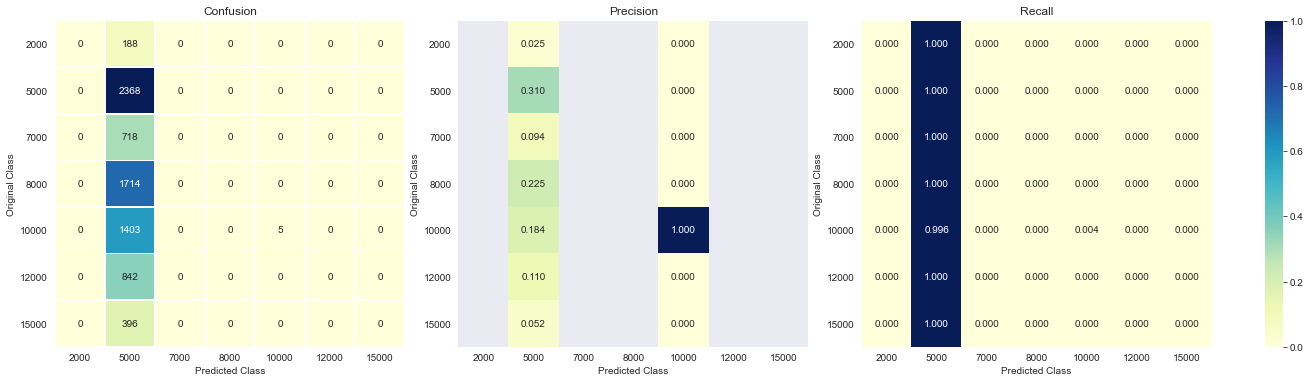

In [125]:
predictions_test = random_forest_predictions(test_df, forest)
miss_class = np.count_nonzero((predictions_test.values - y_test)) / y_test.shape[0]
print('Miss_classified: %.4f' % miss_class)
print('Weighted loss:%.3f' % ch.custom_weighted_loss(y_test, predictions_test.values))
mh.plot_matrices(y_test, predictions_test.values, labels)

## Variable importance

In [126]:
(df.corr()**2)["label"].sort_values(ascending = False)[1:]

water_availability           0.145515
social_class_NOT-REVEALED    0.128848
annual_income_band           0.120691
house_area_band              0.062767
sanitary_availability        0.032465
occupants_count              0.027294
loan_installments            0.019033
repayment_behaviour          0.017055
loan_tenure                  0.016947
social_class_OBC             0.013839
young_dependents             0.013308
social_class_BC              0.013127
home_ownership               0.004311
age_band                     0.004222
social_class_OTHERS          0.001865
type_of_house_T2             0.000906
type_of_house_R              0.000610
old_dependents               0.000557
sex_F                        0.000437
sex_M                        0.000427
social_class_GC              0.000309
monthly_expenses_band        0.000220
type_of_house_T1             0.000153
sex_TG                       0.000023
Name: label, dtype: float64